In [1]:
import sys,os
import numpy as np
import pandas as pd
import random

sys.path.append('unpast/') # path to UnPaSt

from unpast.utils.method import prepare_input_matrix, zscore
from unpast.utils.io import read_bic_table, write_bic_table 


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
exprs_file = "../data/UKE_244.exprs.tsv.gz" 
annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)

out_dir = "../unpast_tmp/" 
basename = 'UKE_244'

exprs = pd.read_csv(exprs_file,sep="\t",index_col=0)
print(exprs.shape)
exprs.head(3)

(23758, 244)


,T0063,T0096,T0103,T0249,T0294,T0305,T0315,T0342,T0430,T0644,...,T6985,T6987,T6990,T6991,T6993,T6995,T6999,T7001,T7002,T7003
ENSG00000012124,9.027778,7.575057,7.261707,9.946216,9.903127,7.871454,9.29040,9.726680,9.152180,9.247163,...,5.218529,5.232677,7.880272,4.017847,7.706173,4.629797,5.397713,8.116292,9.344000,9.764757
ENSG00000260083,3.660087,3.141124,2.923667,3.939617,3.530985,3.802634,3.37083,3.531991,3.817024,4.534004,...,2.437952,2.449817,3.532084,3.738694,2.859947,4.268662,3.101250,1.871275,2.633388,1.929429
ENSG00000176887,9.648030,4.776085,6.083604,7.272087,2.432884,6.795860,0.00000,6.245121,8.322694,3.000023,...,8.648666,6.330015,8.254377,3.632195,3.616804,4.629797,5.111689,4.083328,6.367058,5.607441


In [3]:
gene_info = pd.read_csv("../data/gene_id_mapping.tsv", sep ="\t",index_col=0)
gene_info.set_index("ensembl_gene_id",inplace=True)
ens2hgnc = gene_info["hgnc_symbol"].dropna().to_dict() 
def rename_gene(g,mapper=ens2hgnc, not_mapped = "", keep_not_mapped = False):
    if g in ens2hgnc.keys():
        return mapper[g]
    else:
        if keep_not_mapped:
            return g
        else:
            return not_mapped
        
def rename_genes_in_biclusters(biclusters, rename_gene_func = rename_gene):
    renamed_biclusters = biclusters.copy()
    renamed_biclusters["genes"] = renamed_biclusters["genes"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_up"] = renamed_biclusters["genes_up"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_down"] = renamed_biclusters["genes_down"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    return renamed_biclusters

def rename_genes_in_exprs(data, rename_gene_func = rename_gene):
    renamed_data = data.copy()
    renamed_data.index = [rename_gene_func(x, keep_not_mapped=True) for x in renamed_data.index ]
    # drop duplicates 
    renamed_data = renamed_data[~renamed_data.index.duplicated()]
    return renamed_data

In [4]:
analysis_seed =  42
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics = read_bic_table(outfile)
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics.shape[0]

234

In [5]:
# subset biclusters to 181 samples used in survival analysis
uke_bics["samples"] =  uke_bics["samples"].apply(lambda x : x.intersection(set(annot.index.values)))
uke_bics["n_samples"] = uke_bics["samples"].apply(lambda x :len(x) )
uke_bics['sample_indexes'] = uke_bics['samples'].apply(lambda samples: set([i for i,val in enumerate(annot.index.values) if val in samples ]))
flip_bics = uke_bics.loc[uke_bics["n_samples"]>annot.shape[0]/2,:].index.values
uke_bics.loc[flip_bics,"samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x : set(annot.index.values).difference(x))
uke_bics.loc[flip_bics,"n_samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x :len(x) )
d = {"UP":"DOWN","DOWN":"UP","BOTH":"BOTH"}
uke_bics.loc[flip_bics,"direction"] = uke_bics.loc[flip_bics,"direction"].apply(lambda x: d[x])
genes_up  = uke_bics.loc[flip_bics,"genes_up"].copy()
genes_down  = uke_bics.loc[flip_bics,"genes_down"].copy()
uke_bics.loc[flip_bics,"genes_up"] = genes_down
uke_bics.loc[flip_bics,"genes_down"] = genes_up 
uke_bics.loc[flip_bics,:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
16,1.977286,3,90,"{ENSG00000218048, ENSG00000146166, ENSG0000021...","{T6987, T6717, T2388, T6945, T4979, T6926, T61...",{},"{ENSG00000218048, ENSG00000146166, ENSG0000021...","{5480, 14974, 6671}","{2, 4, 5, 6, 7, 11, 12, 14, 15, 17, 20, 21, 25...",DOWN,10,seed=107473_58 seed=116739_22 seed=146316_21 s...,"{ENSG00000218048, ENSG00000218274, LGSN}"
107,1.607980,4,88,"{ENSG00000131668, ENSG00000159556, ENSG0000025...","{T6513, T4979, T6159, T6679, T6698, T4545, T24...",{},"{ENSG00000131668, ENSG00000159556, ENSG0000025...","{17113, 11842, 14772, 23567}","{3, 5, 8, 11, 12, 15, 19, 20, 22, 31, 33, 35, ...",DOWN,10,seed=107473_138 seed=116739_126 seed=146316_85...,"{ISL1-DT, BARX1, ISL2, ISL1}"
139,1.563189,3,88,"{ENSG00000166342, ENSG00000265579, ENSG0000013...","{T6549, T6717, T6513, T4979, T6926, T6679, T66...",{},"{ENSG00000166342, ENSG00000265579, ENSG0000013...","{7981, 22813, 20646}","{0, 1, 3, 5, 12, 13, 14, 21, 22, 24, 25, 26, 3...",DOWN,8,seed=116739_138 seed=146316_151 seed=234053_12...,"{CHRNA1, NETO1, ENSG00000265579}"
143,1.558024,6,87,"{ENSG00000196109, ENSG00000213973, ENSG0000026...","{T1637, T6549, T6945, T2388, T6513, T4979, T66...","{ENSG00000196109, ENSG00000213973, ENSG0000026...",{},"{10355, 7379, 19573, 9331, 2202, 7582}","{0, 4, 5, 6, 7, 8, 10, 13, 16, 18, 19, 21, 25,...",UP,10,seed=107473_108 seed=116739_117 seed=146316_12...,"{BNIP3P30, VN1R85P, ZNF99, ZNF676, BNIP3P28, Z..."
184,1.492052,6,89,"{ENSG00000165202, ENSG00000224318, ENSG0000022...","{T6549, T6987, T6717, T4979, T6926, T6679, T66...",{},"{ENSG00000165202, ENSG00000224318, ENSG0000022...","{5056, 8193, 17123, 3875, 21033, 6108}","{0, 2, 5, 6, 8, 9, 10, 11, 12, 15, 16, 20, 22,...",DOWN,17,seed=107473_170 seed=116739_165 seed=146316_12...,"{CHL1-AS2, OR1H1P, OR1Q1, ENSG00000229245, ENS..."
193,1.483090,9,87,"{ENSG00000249049, ENSG00000204711, ENSG0000017...","{T6717, T6945, T2388, T6513, T4979, T6926, T66...","{ENSG00000249049, ENSG00000204711, ENSG0000017...",{},"{19683, 15972, 17769, 12811, 2859, 6155, 7277,...","{1, 3, 9, 10, 12, 13, 17, 18, 25, 27, 28, 30, ...",UP,6,seed=107473_169 seed=116739_125 seed=234053_12...,"{NRG4, CFAP95, WDR49, ENSG00000249049, MIR924H..."
195,1.478351,5,82,"{ENSG00000260725, ENSG00000229769, ENSG0000026...","{T6549, T6926, T6698, T2434, T1961, T6965, T40...","{ENSG00000260725, ENSG00000229769, ENSG0000026...",{},"{11042, 19109, 15626, 22702, 8246}","{0, 2, 3, 5, 7, 8, 10, 12, 13, 14, 18, 21, 22,...",UP,9,seed=107473_94 seed=116739_215 seed=146316_120...,"{ENSG00000260725, TRBV10-2, MAN1A2P1, TRBV7-4,..."


In [6]:
uke_bics = uke_bics.loc[uke_bics['SNR']>1.5,:]
uke_bics = uke_bics.loc[uke_bics['n_genes']>=2,:]
uke_bics.shape[0]

177

In [7]:
exprs_tcga = pd.read_csv("../data/TCGA-OV_noENSG00000230417.exprs.tsv",sep="\t",index_col=0)
print(exprs_tcga.shape)
exprs_tcga.head(2)

(17400, 426)


,TCGA-13-1485-01,TCGA-25-1315-01,TCGA-09-0369-01,TCGA-24-1419-01,TCGA-29-1761-01,TCGA-24-1845-01,TCGA-24-2293-01,TCGA-29-A5NZ-01,TCGA-29-1768-01,TCGA-24-1426-01,...,TCGA-61-1733-01,TCGA-23-1107-01,TCGA-24-1930-01,TCGA-24-1430-01,TCGA-61-1721-01,TCGA-29-1784-01,TCGA-13-0725-01,TCGA-13-1481-01,TCGA-61-1907-01,TCGA-24-2254-01
sample,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,11.5358,12.3470,12.0628,12.2235,10.7280,11.5954,11.0225,12.5459,11.4551,11.3164,...,11.1153,10.6617,11.1029,12.4840,11.8733,11.8160,12.1340,10.9767,12.0190,12.1592
ENSG00000000005,0.9572,2.5527,4.5745,2.1751,0.7948,0.0000,4.2955,1.1094,4.7731,1.4357,...,0.8523,0.0000,2.8520,3.1486,9.5955,0.7357,3.2332,3.9844,2.4521,3.3307


116 116


array([  3,   4,   7,   8,   9,  10,  13,  15,  18,  20,  21,  22,  23,
        25,  26,  27,  28,  31,  33,  34,  35,  39,  40,  41,  42,  43,
        46,  47,  48,  49,  51,  54,  56,  57,  59,  60,  62,  63,  67,
        69,  70,  71,  72,  73,  74,  75,  77,  80,  81,  82,  83,  84,
        85,  86,  89,  90,  91,  95,  98,  99, 100, 101, 103, 104, 105,
       106, 107, 109, 113, 114, 115, 116, 117, 120, 121, 122, 124, 125,
       126, 127, 128, 129, 130, 131, 134, 135, 136, 138, 139, 140, 141,
       142, 143, 144, 146, 147, 148, 149, 150, 152, 155, 156, 157, 158,
       160, 161, 163, 167, 168, 169, 170, 171, 173, 174, 175, 176])

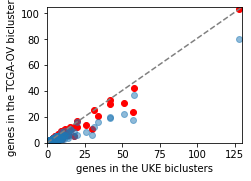

In [8]:
from unpast.utils.method import cluster_samples, update_bicluster_data
from aux import make_similar_biclusters

exprs_tcga_z = prepare_input_matrix(exprs_tcga, min_n_samples=5,ceiling=3)
tcga_bics, gene_sets_stat_tcga= make_similar_biclusters(uke_bics,exprs_tcga_z,seed=analysis_seed)
df = gene_sets_stat_tcga.loc[gene_sets_stat_tcga["n_genes2"]>=2,:]
#df = df.loc[df["SNR2"]>1.5,:]
sele_tcga_ids = df.index.values 

tmp = plt.figure(figsize = (3.5,2.5))
gene_sets_stat_tcga = gene_sets_stat_tcga.loc[sele_tcga_ids,:]
tmp = plt.scatter(gene_sets_stat_tcga["n_genes"],gene_sets_stat_tcga["n_genes_measured"],color="red")
tmp = plt.scatter(gene_sets_stat_tcga["n_genes"],gene_sets_stat_tcga["n_genes2"],alpha=0.5)
tmp = plt.xlim(0,130)
tmp = plt.ylim(0,105)
tmp = plt.plot([0, 130], [0, 105], ls="--",color="grey")
tmp = plt.xlabel("genes in the UKE biclusters")
tmp = plt.ylabel("genes in the TCGA-OV biclusters")

print(len(sele_tcga_ids), tcga_bics.shape[0])
sele_tcga_ids

In [9]:
tcga_bics["genes_renamed"] = tcga_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b = tcga_bics.copy()
b.sort_values(by = "n_genes",ascending = False).head(30)

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
129,"{6, 7, 8, 15, 16, 17, 25, 27, 28, 29, 30, 31, ...",180,"{ENSG00000239961, ENSG00000211946, ENSG0000010...",80,UP,"{TCGA-13-0911-01, TCGA-31-1951-01, TCGA-61-209...","{4138, 2155, 5763, 7323, 16572, 16079, 16087, ...","{ENSG00000239961, ENSG00000211946, ENSG0000010...",{},1.613471,"{IGKV1-27, IGKV3-11, IGKV1D-13, IGHV3-23, IGLV..."
70,"{0, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 22, 2...",167,"{ENSG00000198108, ENSG00000246430, ENSG0000021...",37,UP,"{TCGA-24-1435-01, TCGA-24-2033-01, TCGA-13-090...","{8194, 4743, 3469, 16397, 6416, 9756, 16924, 1...","{ENSG00000198108, ENSG00000246430, ENSG0000021...",{},1.740507,"{PLAU, NETO1, PRRX1, ALPK2, C1QTNF6, OMD, KCNA..."
69,"{0, 3, 5, 8, 10, 12, 15, 20, 22, 23, 27, 31, 3...",165,"{ENSG00000226421, ENSG00000237945, ENSG0000018...",22,DOWN,"{TCGA-24-1435-01, TCGA-24-1471-01, TCGA-13-090...","{16656, 15769, 12954, 282, 16027, 11036, 16925...",{},"{ENSG00000226421, ENSG00000237945, ENSG0000018...",1.680792,"{CCDC162P, SLCO1A2, POU6F2-AS2, BBOX1-AS1, SPI..."
40,"{1, 2, 7, 9, 13, 14, 16, 18, 25, 32, 34, 38, 4...",103,"{ENSG00000145626, ENSG00000157851, ENSG0000020...",20,UP,"{TCGA-13-0901-01, TCGA-24-1426-01, TCGA-29-241...","{11393, 17027, 3465, 15636, 1944, 14371, 9765,...","{ENSG00000145626, ENSG00000157851, ENSG0000020...",{},1.595897,"{FGF19, TSPAN19, CECR2, LINC01163, PIANP, ADGR..."
27,"{0, 1, 2, 3, 9, 14, 18, 21, 25, 32, 37, 38, 39...",173,"{ENSG00000198739, ENSG00000124205, ENSG0000018...",19,UP,"{TCGA-23-1024-01, TCGA-24-1426-01, TCGA-31-194...","{14217, 4883, 6420, 13590, 291, 7860, 63, 1632...","{ENSG00000198739, ENSG00000124205, ENSG0000018...",{},1.825415,"{JPH4, DLK1, TCERG1L, DCAF8L2, LINC01391, NR5A..."
57,"{1, 7, 9, 13, 14, 16, 18, 19, 21, 25, 29, 30, ...",161,"{ENSG00000231532, ENSG00000226421, ENSG0000017...",18,UP,"{TCGA-23-1024-01, TCGA-24-2033-01, TCGA-24-142...","{16823, 13188, 12869, 12584, 13866, 15626, 156...","{ENSG00000231532, ENSG00000226421, ENSG0000017...",{},1.56853,"{HTR2C, OR5BH1P, TRDN, VCX, LINC00645, OFCC1, ..."
63,"{0, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 22, 2...",148,"{ENSG00000182747, ENSG00000225826, ENSG0000008...",16,UP,"{TCGA-24-1435-01, TCGA-24-2033-01, TCGA-13-090...","{12451, 15300, 1671, 10890, 1419, 12602, 3469,...","{ENSG00000182747, ENSG00000225826, ENSG0000008...",{},1.719146,"{GRP, TBX5, LINC00626, SERPINB7, SLC35D3, LINC..."
85,"{0, 1, 11, 14, 20, 21, 32, 33, 34, 37, 38, 44,...",102,"{ENSG00000162598, ENSG00000226321, ENSG0000016...",16,UP,"{TCGA-24-1471-01, TCGA-61-2092-01, TCGA-57-199...","{12257, 13315, 11560, 15340, 15597, 14607, 103...","{ENSG00000171595, ENSG00000162598, ENSG0000022...",{},1.596508,"{C1orf87, CDHR4, STOML3, GMNC, DNAI2, GSTA3, C..."
122,"{0, 1, 2, 3, 7, 9, 13, 14, 16, 18, 21, 25, 27,...",147,"{ENSG00000117477, ENSG00000259905, ENSG0000019...",12,UP,"{TCGA-13-0901-01, TCGA-24-1426-01, TCGA-29-241...","{17027, 13092, 5926, 4231, 7112, 10675, 14067,...","{ENSG00000117477, ENSG00000259905, ENSG0000019...",{},1.466208,"{EPHA7, BEX1, NPAP1, MYH7, JPH4, SULT1C4, CCDC..."
155,"{0, 1, 4, 5, 9, 11, 14, 21, 25, 32, 34, 37, 38...",135,"{ENSG00000124237, ENSG00000174776, ENSG0000018...",11,UP,"{TCGA-24-1471-01, TCGA-24-1426-01, TCGA-29-241...","{4897, 9448, 11849, 13385, 13067, 4846, 11634,...","{ENSG00000124237, ENSG00000174776, ENSG0000018...",{},1.443565,"{WDR49, DAW1, ADGB, C20orf85, TEKT4, FAM81B, C..."


# DASL

In [10]:
exprs_dasl = pd.read_csv("../data/DASL_377.exprs.tsv.gz",sep="\t",index_col=0)
print(exprs_dasl.shape)
exprs_dasl_z = prepare_input_matrix(exprs_dasl, min_n_samples=5,ceiling=3)
exprs_dasl.head(2)

(19369, 377)


,X5800701006_B,X5800701006_C,X5800701006_D,X5800701006_E,X5800701006_F,X5800701006_G,X5800701006_I,X5800701006_J,X5800701006_K,X5800701006_L,...,X6828280034_C,X6828280034_F,X6828280034_H,X6828280034_I,X6828280034_J,X6828280034_K,X6828280034_L,X6828301015_B,X6828301015_C,X6828301015_D
ENSG00000000003,9.909752,9.525017,9.389951,8.906697,8.872511,9.435739,8.682605,8.263090,10.024749,7.500624,...,8.821913,9.981615,8.306561,9.164281,7.774171,8.969784,10.373839,9.417089,9.138731,8.597400
ENSG00000000005,5.796944,6.934209,6.029834,8.056683,5.848083,10.293842,12.859131,5.729206,7.629308,5.864953,...,7.105938,6.985320,7.148474,7.285059,7.248570,8.255288,9.003298,7.328400,7.132316,8.051942


64


array([  3,   7,   8,   9,  10,  13,  20,  22,  23,  26,  27,  31,  34,
        35,  40,  41,  42,  43,  47,  54,  57,  59,  60,  62,  63,  67,
        69,  70,  72,  81,  82,  83,  84,  85,  90,  95,  98,  99, 100,
       101, 103, 106, 107, 109, 117, 120, 122, 126, 129, 130, 139, 144,
       146, 147, 148, 152, 155, 156, 157, 158, 163, 167, 168, 173])

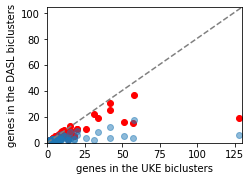

In [11]:
dasl_bics, gene_sets_stat_dasl = make_similar_biclusters(uke_bics, exprs_dasl_z, seed=analysis_seed)
df = gene_sets_stat_dasl.loc[gene_sets_stat_dasl["n_genes2"]>=2,:]
#df = df.loc[df["SNR2"]>1.5,:]
sele_ids_dasl = df.index.values 

gene_sets_stat_dasl = gene_sets_stat_dasl.loc[sele_ids_dasl,:]

tmp = plt.figure(figsize = (3.5,2.5))
tmp = plt.scatter(gene_sets_stat_dasl["n_genes"],gene_sets_stat_dasl["n_genes_measured"],color="red")
tmp = plt.scatter(gene_sets_stat_dasl["n_genes"],gene_sets_stat_dasl["n_genes2"],alpha=0.5)

tmp = plt.xlim(0,130)
tmp = plt.ylim(0,105)
tmp = plt.plot([0, 130], [0, 105], ls="--",color="grey")
tmp = plt.xlabel("genes in the UKE biclusters")
tmp = plt.ylabel("genes in the DASL biclusters")
print(len(sele_ids_dasl))
sele_ids_dasl

In [12]:
# present in both DASL and TCGA
sele_ids_all = sorted(set(sele_ids_dasl).intersection(sele_tcga_ids))
print(sele_ids_all)
len(sele_ids_all)

[3, 7, 8, 9, 10, 13, 20, 22, 23, 26, 27, 31, 34, 35, 40, 41, 42, 43, 47, 54, 57, 59, 60, 62, 63, 67, 69, 70, 72, 81, 82, 83, 84, 85, 90, 95, 98, 99, 100, 101, 103, 106, 107, 109, 117, 120, 122, 126, 129, 130, 139, 144, 146, 147, 148, 152, 155, 156, 157, 158, 163, 167, 168, 173]


64

64


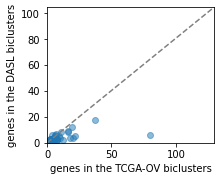

In [13]:
tmp = plt.figure(figsize = (3,2.5))
#tmp = plt.scatter(gene_sets_stat_tcga.loc[sele_ids_all,"n_genes_measured"],gene_sets_stat_dasl.loc[sele_ids_all,"n_genes_measured"],color="red",alpha=0.5)
tmp = plt.scatter(gene_sets_stat_tcga.loc[sele_ids_all,"n_genes2"],gene_sets_stat_dasl.loc[sele_ids_all,"n_genes2"],alpha=0.5)

tmp = plt.xlim(0,130)
tmp = plt.ylim(0,105)
tmp = plt.plot([0, 130], [0, 105], ls="--",color="grey")
tmp = plt.xlabel("genes in the TCGA-OV biclusters")
tmp = plt.ylabel("genes in the DASL biclusters")
print(len(sele_ids_all))
#sele_ids_all

In [14]:
# only DASL
print(sorted(set(sele_ids_dasl).difference(sele_tcga_ids)))
len(set(sele_ids_dasl).difference(sele_tcga_ids))

[]


0

In [15]:
# In TCGA but not in DASL
print(sorted(set(sele_tcga_ids).difference(sele_ids_dasl)))
len(set(sele_tcga_ids).difference(sele_ids_dasl))

[4, 15, 18, 21, 25, 28, 33, 39, 46, 48, 49, 51, 56, 71, 73, 74, 75, 77, 80, 86, 89, 91, 104, 105, 113, 114, 115, 116, 121, 124, 125, 127, 128, 131, 134, 135, 136, 138, 140, 141, 142, 143, 149, 150, 160, 161, 169, 170, 171, 174, 175, 176]


52

In [16]:
len(sele_ids_dasl), len(sele_tcga_ids)


(64, 116)

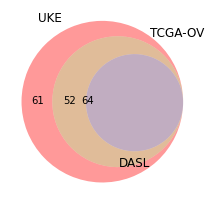

In [17]:
uke_ids = set(uke_bics.index.values)

from matplotlib_venn import venn3, venn2

tmp = plt.figure(figsize = (3.5,3.5))
v = venn3([uke_ids,set(sele_tcga_ids),set(sele_ids_dasl)],
          set_labels=("UKE","TCGA-OV","DASL")
         )
tmp = plt.title("",fontsize=14)


In [18]:
dasl_bics["genes_renamed"] = dasl_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b = dasl_bics.copy()
b.sort_values(by = "n_genes",ascending = False).head(30)

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
70,"{1, 2, 3, 5, 6, 7, 10, 12, 14, 16, 18, 19, 22,...",137,"{ENSG00000182667, ENSG00000178776, ENSG0000024...",18,UP,"{X5801106022_C, X5800701010_E, X5800710047_K, ...","{7172, 11365, 16101, 12488, 14155, 8716, 17239...","{ENSG00000182667, ENSG00000249992, ENSG0000014...",{},1.584777,"{NTM, MMP13, MMP11, VCAN, PLAU, PRRX1, LRRC15,..."
27,"{0, 1, 8, 11, 13, 17, 20, 21, 26, 28, 31, 32, ...",142,"{ENSG00000147465, ENSG00000124205, ENSG0000017...",12,UP,"{X5800744005_G, X5801106022_C, X5800744005_C, ...","{514, 13734, 8552, 7930, 14701, 17966, 2159, 5...","{ENSG00000147465, ENSG00000124205, ENSG0000014...",{},1.581703,"{LRRC3B, PROK1, DLK1, NR5A1, ALKAL2, EDN3, AMH..."
85,"{257, 132, 260, 8, 268, 144, 17, 146, 20, 21, ...",61,"{ENSG00000162598, ENSG00000166959, ENSG0000018...",9,UP,"{X6828280034_I, X5800701027_F, X5800701029_I, ...","{12384, 13735, 6408, 12105, 15049, 11377, 1448...","{ENSG00000162598, ENSG00000166959, ENSG0000018...",{},1.66575,"{C1orf87, CDHR4, STOML3, DNAI2, CDC20B, FRMPD2..."
155,"{0, 257, 132, 134, 8, 9, 265, 268, 141, 269, 1...",75,"{ENSG00000124237, ENSG00000157330, ENSG0000017...",8,UP,"{X6828280034_I, X5800701027_F, X5800701029_I, ...","{5253, 9608, 489, 14728, 5197, 15131, 12958, 5...","{ENSG00000124237, ENSG00000174776, ENSG0000015...",{},1.652505,"{WDR49, DAW1, CFAP107, C20orf85, CLXN, CACNG6,..."
63,"{2, 3, 5, 6, 7, 10, 12, 14, 16, 18, 22, 25, 29...",126,"{ENSG00000182747, ENSG00000082196, ENSG0000009...",8,UP,"{X5800701010_E, X5800710047_K, X5800710038_H, ...","{1508, 13963, 1966, 1551, 6578, 14167, 792, 4989}","{ENSG00000182747, ENSG00000082196, ENSG0000009...",{},1.417766,"{GRP, SLC35D3, COL11A1, CSMD2, EPYC, MAB21L2, ..."
10,"{0, 1, 8, 11, 13, 17, 20, 21, 26, 28, 31, 32, ...",164,"{ENSG00000147465, ENSG00000127324, ENSG0000003...",7,UP,"{X5800744005_G, X5801106022_C, X5800744005_C, ...","{5632, 514, 8552, 6742, 15383, 7034, 63}","{ENSG00000147465, ENSG00000127324, ENSG0000003...",{},1.519088,"{TSPAN8, NR5A1, ALKAL2, AMHR2, ARX, CASR, STAR}"
20,"{3, 5, 11, 14, 15, 28, 29, 35, 36, 42, 46, 47,...",102,"{ENSG00000112761, ENSG00000263961, ENSG0000012...",6,DOWN,"{X6828280034_I, X5801106022_C, X5800744005_C, ...","{13923, 18339, 5420, 3925, 2427, 11839}",{},"{ENSG00000112761, ENSG00000263961, ENSG0000012...",1.185527,"{KLK7, WFDC2, CCN6, PAX8, MUC16, RHEX}"
83,"{130, 132, 8, 137, 138, 11, 14, 272, 17, 147, ...",57,"{ENSG00000171564, ENSG00000275410, ENSG0000024...",6,UP,"{X5800701027_F, X5801106022_C, X5800701057_H, ...","{2247, 17864, 18608, 18035, 12378, 12380}","{ENSG00000171564, ENSG00000275410, ENSG0000024...",{},1.532817,"{FGA, HNF1A-AS1, GBA3, CCDC198, HNF1B, FGB}"
129,"{5, 6, 7, 13, 18, 19, 24, 26, 28, 29, 30, 33, ...",105,"{ENSG00000105369, ENSG00000143297, ENSG0000024...",6,UP,"{X6828280034_I, X5800744005_C, X5800701027_H, ...","{4423, 2953, 17839, 10493, 6239, 7967}","{ENSG00000105369, ENSG00000143297, ENSG0000024...",{},1.318776,"{TNFRSF13B, FCRLA, FCRL1, CD79A, AMPD1, FCRL5}"
99,"{1, 3, 5, 6, 7, 10, 11, 14, 16, 19, 22, 27, 29...",161,"{ENSG00000165124, ENSG00000102359, ENSG0000016...",5,UP,"{X6828280034_I, X5801106022_C, X5800701010_E, ...","{263, 10953, 5617, 2556, 10719}","{ENSG00000165124, ENSG00000164176, ENSG0000010...",{},1.299464,"{FMO1, EDIL3, OMD, SVEP1, SRPX2}"


# Find biclusters best matching known molecular subtypes

In [19]:
def make_known_groups(annot, target_col="genefu_z", verbose=False):
    samples = set(annot.index.values)
    if verbose:
        print("Total samples:", len(samples), file=sys.stdout)
    annot = annot.loc[list(samples), :]
    groups = set(annot.loc[:, target_col].values)

    known_groups = {}
    for group in groups:
        if group == group:
            group_samples = set(annot.loc[annot[target_col] == group, :].index.values)
            group_samples = group_samples.intersection(samples)
            if len(group_samples) > int(len(samples) / 2):
                print("take complement of ", group, file=sys.stderr)
                group_samples = samples.difference(group_samples)
            known_groups[
                group
            ] = group_samples  # {"set":group_samples,"complement": samples.difference(group_samples)}
            if verbose:
                print(
                    group,
                    round(len(group_samples) / len(samples), 2),
                    len(group_samples),
                    len(samples.difference(group_samples)),
                )
    return known_groups

In [20]:
from collections import OrderedDict

subt_dict = {"DIF_consensus":'differentiated',
            "MES_consensus": 'mesenchymal',
            "IMR_consensus":'immunoreactive',
            "PRO_consensus": 'proliferative',
            "NA":"NA"}
subt_dict.update({'DIF': 'differentiated',
 'MES': 'mesenchymal',
 'IMR': 'immunoreactive',
 'PRO': 'proliferative',
 'NA': 'NA'}) 
color_dict = {"consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Verhaak":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

color_dict['subtype'] = OrderedDict({'proliferative': 'lime',
                                     'mesenchymal': 'orange',
                                     'differentiated': 'cyan',
                                     'immunoreactive': 'magenta',
                                    "PRO":"lime","MES":"orange","DIF":"cyan","IMR": "magenta"})

In [21]:
pm = "ARI"

### UKE

In [22]:
annot_uke = annot
exprs_uke_z = prepare_input_matrix(exprs.loc[:,annot_uke.index], min_n_samples=5,ceiling=3)
subt_uke = pd.read_csv("../data/OVcancer_subtypes/UKE181_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_uke["subtype"] = subt_uke["consensusOV"].apply(lambda x: subt_dict[x])
subt_uke.head(2)

,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
sample_id,,,,,,
T0063,DIF_consensus,MES,C4_mescL,C1,nonAngiogenic,differentiated
T0096,DIF_consensus,DIF,C3_profL,C2,Angiogenic,differentiated


In [23]:
known_groups_uke = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_uke[subt] = make_known_groups(subt_uke, target_col = subt)
known_groups_uke.keys()

take complement of  nonAngiogenic


dict_keys(['subtype', 'Verhaak', 'Konecny', 'Helland', 'Bentink'])

In [24]:
from unpast.utils.eval import calculate_perfromance
performances, best_matches_uke = calculate_perfromance(uke_bics.loc[sele_ids_all,:],
                                                   known_groups_uke,
                                                   set(subt_uke.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.316782
Verhaak    0.226080
Konecny    0.232506
Helland    0.322454
Bentink    0.553832
dtype: float64

In [25]:
best_matches_uke.head(4)

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
immunoreactive,81,0.262525,0.276243,0.000048,True,"{T1637, T6716, T6961, T6731, T6656, T6759, T69...",47,subtype
differentiated,157,0.345797,0.265193,0.000048,True,"{T6549, T6556, T6960, T6939, T2388, T6513, T66...",62,subtype
mesenchymal,63,0.260488,0.309392,0.000067,True,"{T1637, T6987, T6717, T6945, T6159, T3858, T03...",90,subtype
proliferative,40,0.482436,0.149171,0.000058,True,"{T6960, T6939, T6656, T6941, T6795, T6698, T19...",32,subtype


In [26]:
from unpast.utils.figs import draw_heatmap2  

In [27]:
exprs_uke_z_rn = rename_genes_in_exprs(exprs_uke_z)

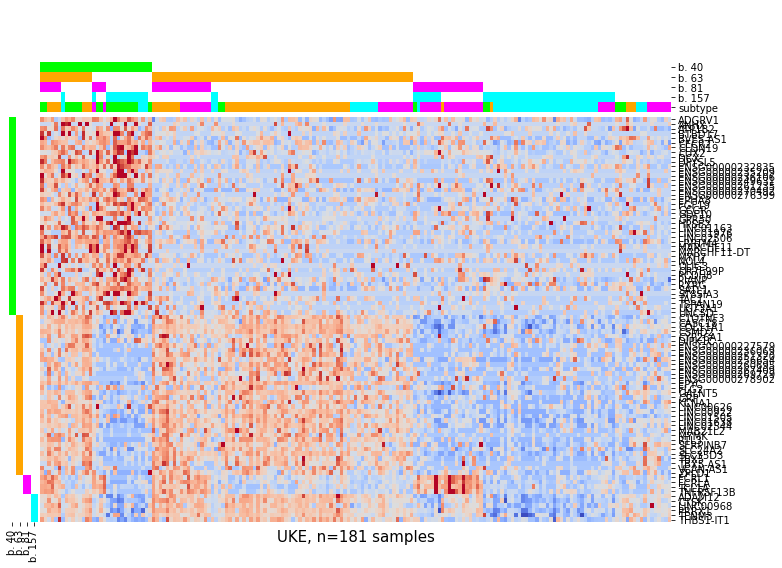

In [28]:
#cl = "Verhaak"
cl = "subtype"
#cl= "Bentink"

best_matches = best_matches_uke
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))
bics = rename_genes_in_biclusters(uke_bics.copy())
bics["genes"] = bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
bics["genes_up"] = bics["genes_up"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
bics["genes_down"] = bics["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])
    
fig, samples, colors = draw_heatmap2(exprs_uke_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_uke.loc[:,["subtype"]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  legend_n_cols = 0,
                  no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%annot_uke.shape[0], fontsize=15)

### DASL

In [29]:
annot_dasl = pd.read_csv("../data/DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
subt_dasl = pd.read_csv("../data/OVcancer_subtypes//DASL_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_dasl["subtype"] = subt_dasl["consensusOV"].apply(lambda x: subt_dict[x])
known_groups_dasl = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_dasl[subt] = make_known_groups(subt_dasl, target_col = subt)
subt_dasl.head(2)

take complement of  nonAngiogenic


,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
sample_id,,,,,,
X5800701006_B,DIF_consensus,DIF,C2_diffL,C4,nonAngiogenic,differentiated
X5800701006_C,PRO_consensus,PRO,C3_profL,C5,nonAngiogenic,proliferative


In [30]:
performances, best_matches_dasl = calculate_perfromance(dasl_bics.loc[sele_ids_all,:],
                                                   known_groups_dasl,
                                                   set(subt_dasl.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.254004
Verhaak    0.200750
Konecny    0.260554
Helland    0.333950
Bentink    0.503022
dtype: float64

In [31]:
best_matches_dasl.head(4)

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
immunoreactive,129,0.148846,0.297082,0.000086,True,"{X6828280034_I, X5800744005_C, X5800701027_H, ...",105,subtype
differentiated,155,0.185856,0.297082,0.000122,True,"{X6828280034_I, X5800701027_F, X5800701029_I, ...",75,subtype
mesenchymal,63,0.307652,0.228117,0.000123,True,"{X5800701010_E, X5800710047_K, X5800710038_H, ...",126,subtype
proliferative,40,0.474847,0.177719,0.000101,True,"{X5800701055_I, X5800710047_F, X5800701027_H, ...",80,subtype


In [32]:
exprs_dasl_z_rn = rename_genes_in_exprs(exprs_dasl_z)

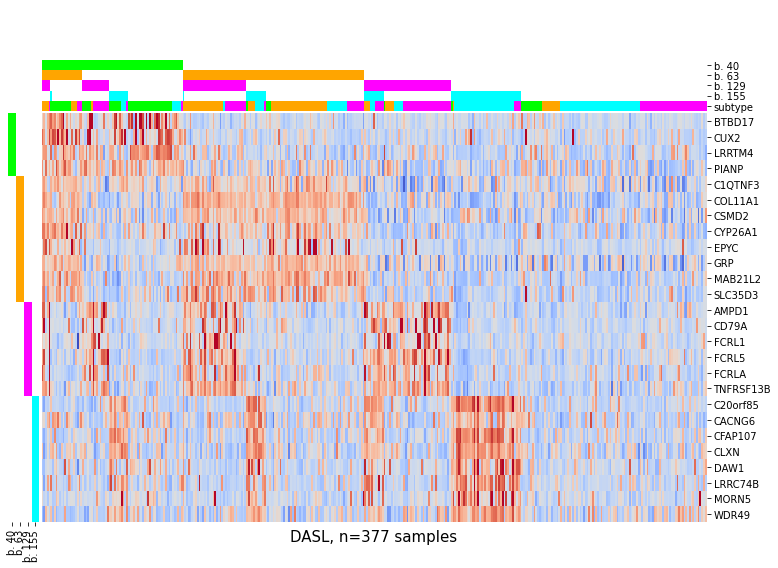

In [33]:
#cl = "Verhaak"
cl = "subtype"
#cl = "Bentink"

best_matches = best_matches_dasl
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))

bics = rename_genes_in_biclusters(dasl_bics.copy())

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])


fig, samples, colors = draw_heatmap2(exprs_dasl_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_dasl.loc[:,[cl]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  legend_n_cols = 0,
                  no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%annot_dasl.shape[0], fontsize=15)

In [34]:
bics.loc[bm_ids,["genes","SNR"]]

,genes,SNR
40,"{CUX2, BTBD17, PIANP, LRRTM4}",1.107424
63,"{GRP, SLC35D3, COL11A1, CSMD2, EPYC, MAB21L2, ...",1.417766
129,"{TNFRSF13B, FCRLA, FCRL1, CD79A, AMPD1, FCRL5}",1.318776
155,"{WDR49, DAW1, CFAP107, C20orf85, CLXN, CACNG6,...",1.652505


### TCGA-OV

In [35]:
subt_tcga = pd.read_csv("../data/OVcancer_subtypes/TCGA_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_tcga["subtype"] = subt_tcga["consensusOV"].apply(lambda x: subt_dict[x])
subt_tcga.index = [ x.replace(".","-")  for x in subt_tcga.index]
known_groups_tcga = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_tcga[subt] = make_known_groups(subt_tcga, target_col = subt)
subt_tcga.head(2)

take complement of  nonAngiogenic


,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
TCGA-13-1485-01,MES_consensus,MES,C3_profL,C1,Angiogenic,mesenchymal
TCGA-25-1315-01,PRO_consensus,PRO,C3_profL,C5,nonAngiogenic,proliferative


In [36]:
performances, best_matches_tcga = calculate_perfromance(tcga_bics.loc[sele_ids_all,:],
                                                   known_groups_tcga,
                                                   set(subt_tcga.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.311318
Verhaak    0.281854
Konecny    0.216633
Helland    0.361247
Bentink    0.743164
dtype: float64

In [37]:
best_matches_tcga.head(4)

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
mesenchymal,63,0.474771,0.234742,0.000072,True,"{TCGA-24-1435-01, TCGA-24-2033-01, TCGA-13-090...",148,subtype
differentiated,85,0.135704,0.269953,0.000186,True,"{TCGA-24-1471-01, TCGA-61-2092-01, TCGA-57-199...",102,subtype
proliferative,40,0.57453,0.204225,0.00007,True,"{TCGA-13-0901-01, TCGA-24-1426-01, TCGA-29-241...",103,subtype
immunoreactive,81,0.157694,0.29108,0.00011,True,"{TCGA-13-0901-01, TCGA-13-0911-01, TCGA-13-141...",144,subtype


In [38]:
exprs_tcga_z_rn = rename_genes_in_exprs(exprs_tcga_z)

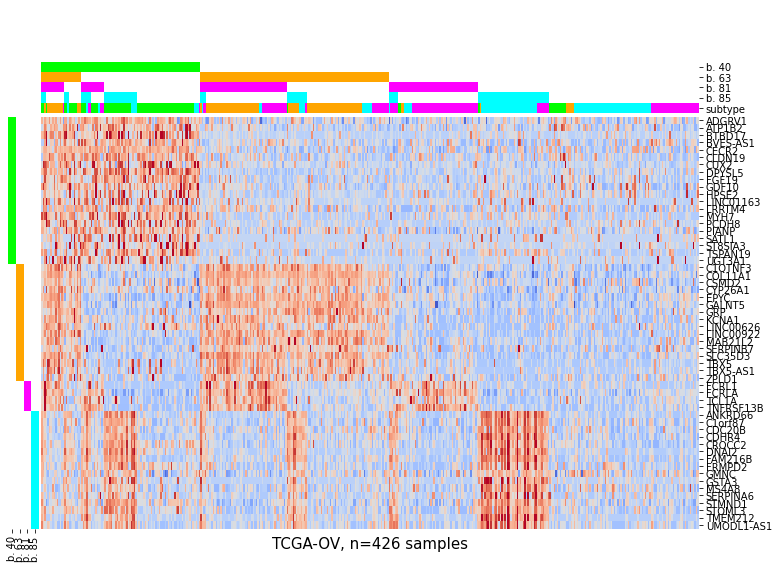

In [39]:
#cl = "Verhaak"
cl = "subtype"
#cl = "Bentink"

best_matches = best_matches_tcga
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))
bics = rename_genes_in_biclusters(tcga_bics.copy())

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])


fig, samples, colors = draw_heatmap2(exprs_tcga_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_tcga.loc[:,[cl]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  legend_n_cols = 0,
                  no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=15)

In [40]:
bics.loc[bm_ids,["genes","SNR"]]

,genes,SNR
40,"{FGF19, TSPAN19, CECR2, LINC01163, PIANP, ADGR...",1.595897
63,"{GRP, TBX5, LINC00626, SERPINB7, SLC35D3, LINC...",1.719146
81,"{FCRLA, FCRL1, TNFRSF13B, TCL1A}",1.433103
85,"{C1orf87, CDHR4, STOML3, GMNC, DNAI2, GSTA3, C...",1.596508


# Conclusion
* bicluster **40** is the best match for **proliferative** and **63** for **mesenchymal** in all three cohorts 
* bicluster **81** is the best match for **immunoreacive** in the UKE and TCGA-OV, **129** in the DASL 
* **differentiated** betst matches with bics. 157, 155 and 85 in the UKE, DASL and TCGA respectively

# Find biclusters dissimilar from known four subtypes

In [41]:
from unpast.utils.eval import  evaluate_overlaps_ARI, apply_bh
max_ARI = 0.1
pval = 0.05

In [42]:
pvals_uke, is_enriched_uke, ari_uke = evaluate_overlaps_ARI(uke_bics, 
                                                            known_groups_uke["subtype"], 
                                                            set(annot_uke.index))
adj_pvals_uke  = apply_bh(pvals_uke)
#adj_pvals_uke["min_adj_pval"] = adj_pvals_uke.min(axis=1)
ari_uke["max_ARI"] = ari_uke[adj_pvals_uke<pval].max(axis=1)
ari_uke["max_ARI"] = ari_uke["max_ARI"].fillna(-1)
uke_ids = set(ari_uke.loc[ari_uke["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(uke_ids ))

118


In [43]:
pvals_dasl, is_enriched_dasl, ari_dasl = evaluate_overlaps_ARI(dasl_bics, 
                                                            known_groups_dasl["subtype"], 
                                                            set(annot_dasl.index))
adj_pvals_dasl  = apply_bh(pvals_dasl)
#adj_pvals_dasl["min_adj_pval"] = adj_pvals_dasl.min(axis=1)
ari_dasl["max_ARI"] = ari_dasl[adj_pvals_dasl<pval].max(axis=1)
ari_dasl["max_ARI"] = ari_dasl["max_ARI"].fillna(-1)
dasl_ids = set(ari_dasl.loc[ari_dasl["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(dasl_ids ))

38


In [44]:
pvals_tcga, is_enriched_tcga, ari_tcga = evaluate_overlaps_ARI(tcga_bics, 
                                                            known_groups_tcga["subtype"], 
                                                            set(subt_tcga.index))
adj_pvals_tcga  = apply_bh(pvals_tcga)
#adj_pvals_tcga["min_adj_pval"] = adj_pvals_tcga.min(axis=1)
ari_tcga["max_ARI"] = ari_tcga[adj_pvals_tcga<pval].max(axis=1)
ari_tcga["max_ARI"] = ari_tcga["max_ARI"].fillna(-1)
tcga_ids = set(ari_tcga.loc[ari_tcga["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(tcga_ids ))

70


In [45]:
# TCGA
print("same with TCGA:",len(uke_ids.intersection(tcga_ids)))
uke_bics.loc[uke_ids.intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False)

same with TCGA: 58


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
129,1.575306,128,86,"{ENSG00000239961, ENSG00000164485, ENSG0000021...","{T1637, T6717, T6945, T6513, T4979, T6926, T38...","{ENSG00000239961, ENSG00000164485, ENSG0000021...",{},"{11777, 14342, 12816, 6161, 11794, 15376, 3093...","{3, 4, 5, 6, 12, 13, 15, 16, 18, 28, 29, 38, 4...",UP,31,seed=107473_103 seed=107473_159 seed=107473_84...,"{IGKV1-27, IGKV3-11, IGKV1D-13, IGHV3-23, IGHJ..."
69,1.693356,51,83,"{ENSG00000226421, ENSG00000259692, ENSG0000023...","{T6549, T6698, T3858, T3100, T6995, T6691, T67...","{ENSG00000226421, ENSG00000259692, ENSG0000023...",{},"{9984, 14093, 18062, 9230, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{ENSG00000259692, ENSG00000259345, CCDC162P, E..."
46,1.761166,30,58,"{ENSG00000181800, ENSG00000185031, ENSG0000022...","{T1637, T6961, T6960, T6939, T2645, T6656, T65...",{},"{ENSG00000181800, ENSG00000185031, ENSG0000022...","{21251, 21130, 9099, 11538, 17171, 1436, 23071...","{0, 131, 135, 8, 12, 17, 145, 20, 150, 153, 26...",DOWN,13,seed=107473_57 seed=116739_54 seed=146316_108 ...,"{SLC2A3P2, TSPO2, ERVFRD-3, RIC1, ENSG00000271..."
155,1.542546,15,66,"{ENSG00000124237, ENSG00000262890, ENSG0000015...","{T6549, T6716, T6556, T6960, T3644, T6939, T26...","{ENSG00000124237, ENSG00000262890, ENSG0000015...",{},"{11735, 14330, 1605, 15750, 12811, 7083, 21837...","{0, 129, 2, 131, 6, 7, 137, 11, 139, 140, 141,...",UP,10,seed=107473_167 seed=116739_197 seed=146316_14...,"{WDR49, ENSG00000262890, CFAP107, ADGB, C20orf..."
101,1.619774,14,89,"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{T1637, T6926, T6698, T3858, T2434, T6965, T66...",{},"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{12257, 19009, 16419, 15241, 522, 10173, 6256,...","{0, 8, 12, 20, 24, 25, 26, 30, 33, 34, 35, 36,...",DOWN,19,seed=107473_116 seed=116739_107 seed=116739_49...,"{MIR421, ENSG00000281195, KLHL11, ENSG00000227..."
60,1.727762,14,35,"{ENSG00000235221, ENSG00000258128, ENSG0000010...","{T6549, T6961, T6716, T6731, T6726, T6759, T67...","{ENSG00000235221, ENSG00000258128, ENSG0000010...",{},"{770, 15587, 5283, 17766, 22890, 13613, 10736,...","{1, 129, 4, 133, 6, 139, 13, 15, 17, 18, 146, ...",UP,10,seed=107473_22 seed=116739_27 seed=146316_38 s...,"{MIR548XHG, LINC00383, CGB2, LINC00355, ENSG00..."
176,1.500281,11,78,"{ENSG00000233714, ENSG00000150201, ENSG0000023...","{T6549, T6926, T6159, T3858, T6965, T3100, T69...","{ENSG00000233714, ENSG00000150201, ENSG0000023...",{},"{17760, 21312, 12994, 10857, 20334, 23054, 532...","{4, 6, 9, 10, 11, 13, 15, 17, 18, 21, 25, 27, ...",UP,9,seed=107473_69 seed=116739_174 seed=146316_137...,"{ENSG00000233714, MRPL45P1, ENSG00000215869, E..."
160,1.533328,9,82,"{ENSG00000276269, ENSG00000185038, ENSG0000026...","{T6549, T6926, T6159, T6698, T3858, T2434, T19...","{ENSG00000276269, ENSG00000185038, ENSG0000026...",{},"{17760, 21312, 15300, 13551, 19760, 1490, 5011...","{4, 6, 11, 13, 14, 15, 16, 17, 23, 24, 25, 28,...",UP,10,seed=107473_217 seed=116739_206 seed=146316_17...,"{ENSG00000276269, EPB41L5, ENSG00000268080, MR..."
167,1.525746,9,67,"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{T1637, T6549, T6961, T6987, T6990, T6731, T69...",{},"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{7298, 2914, 5962, 22575, 6193, 6131, 87, 1205...","{130, 5, 133, 7, 135, 137, 10, 138, 12, 13, 13...",DOWN,10,seed=107473_134 seed=116739_67 seed=146316_114...,"{PCDHA12, PCDHA11, PCDHB17P, PCDHA8, PCDHA1, N..."


In [46]:
# DASL
print("same with DASL:",len(uke_ids.intersection(dasl_ids)))
uke_bics.loc[uke_ids.intersection(dasl_ids),:].sort_values(by = "n_genes",ascending = False)

same with DASL: 27


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
69,1.693356,51,83,"{ENSG00000226421, ENSG00000259692, ENSG0000023...","{T6549, T6698, T3858, T3100, T6995, T6691, T67...","{ENSG00000226421, ENSG00000259692, ENSG0000023...",{},"{9984, 14093, 18062, 9230, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{ENSG00000259692, ENSG00000259345, CCDC162P, E..."
60,1.727762,14,35,"{ENSG00000235221, ENSG00000258128, ENSG0000010...","{T6549, T6961, T6716, T6731, T6726, T6759, T67...","{ENSG00000235221, ENSG00000258128, ENSG0000010...",{},"{770, 15587, 5283, 17766, 22890, 13613, 10736,...","{1, 129, 4, 133, 6, 139, 13, 15, 17, 18, 146, ...",UP,10,seed=107473_22 seed=116739_27 seed=146316_38 s...,"{MIR548XHG, LINC00383, CGB2, LINC00355, ENSG00..."
101,1.619774,14,89,"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{T1637, T6926, T6698, T3858, T2434, T6965, T66...",{},"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{12257, 19009, 16419, 15241, 522, 10173, 6256,...","{0, 8, 12, 20, 24, 25, 26, 30, 33, 34, 35, 36,...",DOWN,19,seed=107473_116 seed=116739_107 seed=116739_49...,"{MIR421, ENSG00000281195, KLHL11, ENSG00000227..."
34,1.831588,9,23,"{ENSG00000255042, ENSG00000265417, ENSG0000018...","{T6549, T6731, T1731, T6726, T6742, T6795, T67...","{ENSG00000255042, ENSG00000265417, ENSG0000018...",{},"{5354, 3118, 6864, 13393, 19121, 3954, 17207, ...","{129, 4, 133, 6, 13, 14, 15, 16, 28, 31, 59, 6...",UP,12,seed=116739_105 seed=116739_7 seed=146316_12 s...,"{PHF2P2, LINC01854, PAGE5, BAGE2, ENSG00000265..."
167,1.525746,9,67,"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{T1637, T6549, T6961, T6987, T6990, T6731, T69...",{},"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{7298, 2914, 5962, 22575, 6193, 6131, 87, 1205...","{130, 5, 133, 7, 135, 137, 10, 138, 12, 13, 13...",DOWN,10,seed=107473_134 seed=116739_67 seed=146316_114...,"{PCDHA12, PCDHA11, PCDHB17P, PCDHA8, PCDHA1, N..."
62,1.721953,8,51,"{ENSG00000196604, ENSG00000269586, ENSG0000026...","{T6549, T6961, T6416, T6731, T6556, T6577, T17...","{ENSG00000196604, ENSG00000269586, ENSG0000026...",{},"{21474, 2658, 6791, 16872, 19022, 14456, 20155...","{130, 4, 5, 6, 7, 132, 9, 136, 137, 139, 13, 1...",UP,10,seed=107473_41 seed=116739_85 seed=146316_35 s...,"{LY6K, CT45A5, ENSG00000260476, POTEF, CT45A3,..."
83,1.662429,8,31,"{ENSG00000171564, ENSG00000275410, ENSG0000024...","{T6731, T6939, T6726, T6878, T0294, T6671, T49...","{ENSG00000171564, ENSG00000275410, ENSG0000024...",{},"{4066, 12483, 10248, 22251, 4524, 2422, 11581,...","{0, 2, 131, 134, 137, 141, 145, 20, 150, 153, ...",UP,23,seed=107473_1 seed=107473_29 seed=116739_2 see...,"{FGA, HNF1A-AS1, GBA3, CCDC198, HNF1B, FGB, B3..."
35,1.815508,8,23,"{ENSG00000248711, ENSG00000163424, ENSG0000010...","{T6549, T6961, T6731, T3974, T6742, T6741, T25...","{ENSG00000248711, ENSG00000163424, ENSG0000010...",{},"{16997, 16326, 9035, 1451, 10192, 7027, 11541,...","{4, 6, 15, 17, 28, 160, 164, 168, 42, 172, 59,...",UP,10,seed=107473_5 seed=116739_8 seed=146316_5 seed...,"{TEX55, COX8C, ENSG00000282306, PAGE4, THUMPD3..."
82,1.662781,7,60,"{ENSG00000235277, ENSG00000127928, ENSG0000024...","{T3644, T6967, T4452, T6717, T6593, T6878, T70...",{},"{ENSG00000235277, ENSG00000127928, ENSG0000024...","{6211, 1733, 17765, 15629, 18062, 14136, 12668}","{0, 128, 130, 3, 5, 134, 7, 8, 135, 10, 138, 1...",DOWN,2,seed=107473_126 seed=26225_183,"{GPR158, ENSG00000235277, KCNMB2-AS1, BBOX1-AS..."


In [47]:
# all
print("same with TCGA and DASL:",len(uke_ids.intersection(dasl_ids).intersection(tcga_ids)))
print(uke_bics.loc[uke_ids.intersection(dasl_ids).intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False).index)
uke_bics.loc[uke_ids.intersection(dasl_ids).intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False)

same with TCGA and DASL: 24
Int64Index([ 69,  60, 101,  34, 167,  62,  35,  82, 126,  67, 100,  41, 152,
             84,  95, 106, 120,   7,  42,  22,  43, 146, 156,  72],
           dtype='int64', name='id')


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
69,1.693356,51,83,"{ENSG00000226421, ENSG00000259692, ENSG0000023...","{T6549, T6698, T3858, T3100, T6995, T6691, T67...","{ENSG00000226421, ENSG00000259692, ENSG0000023...",{},"{9984, 14093, 18062, 9230, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{ENSG00000259692, ENSG00000259345, CCDC162P, E..."
60,1.727762,14,35,"{ENSG00000235221, ENSG00000258128, ENSG0000010...","{T6549, T6961, T6716, T6731, T6726, T6759, T67...","{ENSG00000235221, ENSG00000258128, ENSG0000010...",{},"{770, 15587, 5283, 17766, 22890, 13613, 10736,...","{1, 129, 4, 133, 6, 139, 13, 15, 17, 18, 146, ...",UP,10,seed=107473_22 seed=116739_27 seed=146316_38 s...,"{MIR548XHG, LINC00383, CGB2, LINC00355, ENSG00..."
101,1.619774,14,89,"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{T1637, T6926, T6698, T3858, T2434, T6965, T66...",{},"{ENSG00000135913, ENSG00000178502, ENSG0000028...","{12257, 19009, 16419, 15241, 522, 10173, 6256,...","{0, 8, 12, 20, 24, 25, 26, 30, 33, 34, 35, 36,...",DOWN,19,seed=107473_116 seed=116739_107 seed=116739_49...,"{MIR421, ENSG00000281195, KLHL11, ENSG00000227..."
34,1.831588,9,23,"{ENSG00000255042, ENSG00000265417, ENSG0000018...","{T6549, T6731, T1731, T6726, T6742, T6795, T67...","{ENSG00000255042, ENSG00000265417, ENSG0000018...",{},"{5354, 3118, 6864, 13393, 19121, 3954, 17207, ...","{129, 4, 133, 6, 13, 14, 15, 16, 28, 31, 59, 6...",UP,12,seed=116739_105 seed=116739_7 seed=146316_12 s...,"{PHF2P2, LINC01854, PAGE5, BAGE2, ENSG00000265..."
167,1.525746,9,67,"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{T1637, T6549, T6961, T6987, T6990, T6731, T69...",{},"{ENSG00000251664, ENSG00000255622, ENSG0000020...","{7298, 2914, 5962, 22575, 6193, 6131, 87, 1205...","{130, 5, 133, 7, 135, 137, 10, 138, 12, 13, 13...",DOWN,10,seed=107473_134 seed=116739_67 seed=146316_114...,"{PCDHA12, PCDHA11, PCDHB17P, PCDHA8, PCDHA1, N..."
62,1.721953,8,51,"{ENSG00000196604, ENSG00000269586, ENSG0000026...","{T6549, T6961, T6416, T6731, T6556, T6577, T17...","{ENSG00000196604, ENSG00000269586, ENSG0000026...",{},"{21474, 2658, 6791, 16872, 19022, 14456, 20155...","{130, 4, 5, 6, 7, 132, 9, 136, 137, 139, 13, 1...",UP,10,seed=107473_41 seed=116739_85 seed=146316_35 s...,"{LY6K, CT45A5, ENSG00000260476, POTEF, CT45A3,..."
35,1.815508,8,23,"{ENSG00000248711, ENSG00000163424, ENSG0000010...","{T6549, T6961, T6731, T3974, T6742, T6741, T25...","{ENSG00000248711, ENSG00000163424, ENSG0000010...",{},"{16997, 16326, 9035, 1451, 10192, 7027, 11541,...","{4, 6, 15, 17, 28, 160, 164, 168, 42, 172, 59,...",UP,10,seed=107473_5 seed=116739_8 seed=146316_5 seed...,"{TEX55, COX8C, ENSG00000282306, PAGE4, THUMPD3..."
82,1.662781,7,60,"{ENSG00000235277, ENSG00000127928, ENSG0000024...","{T3644, T6967, T4452, T6717, T6593, T6878, T70...",{},"{ENSG00000235277, ENSG00000127928, ENSG0000024...","{6211, 1733, 17765, 15629, 18062, 14136, 12668}","{0, 128, 130, 3, 5, 134, 7, 8, 135, 10, 138, 1...",DOWN,2,seed=107473_126 seed=26225_183,"{GPR158, ENSG00000235277, KCNMB2-AS1, BBOX1-AS..."
126,1.585362,7,60,"{ENSG00000124785, ENSG00000253293, ENSG0000025...","{T6987, T6737, T6556, T6731, T6967, T6939, T26...","{ENSG00000124785, ENSG00000253293, ENSG0000025...",{},"{11360, 22045, 11506, 8052, 17307, 2845, 5566}","{129, 4, 132, 135, 10, 11, 143, 17, 18, 147, 2...",UP,10,seed=107473_61 seed=116739_71 seed=146316_88 s...,"{HOXA4, HOXA13, NRN1, HOXD13, HOXA10-AS, HOXA1..."


In [48]:
# show some biclusters with many genes in UKE and TCGA
sele_bics = [84]

highlight_genes = []
for bic_id in sele_bics:
    genes = dasl_bics.loc[bic_id,"genes"]| tcga_bics.loc[bic_id,"genes"]
    genes = genes.intersection(uke_bics.loc[bic_id,"genes"])
    highlight_genes+= sorted(genes)
highlight_genes = sorted(set(highlight_genes))
highlight_genes =  [rename_gene(x, keep_not_mapped=True) for x in highlight_genes]

w = 6
fs = 12 # Font size

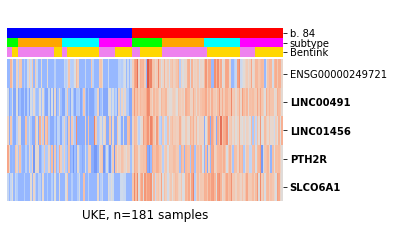

In [49]:
bics = rename_genes_in_biclusters(uke_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),12)
if w>h:
    cr = max(min(0.015,0.05*h/12),0.05)
else:
    cr = min(max(0.015,0.015*h/12),0.05)
fig, samples, colors = draw_heatmap2(exprs_uke_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_uke.loc[:,["subtype","Bentink"]], #
                    #annot = subt_uke.loc[:,["subtype"]],
                    color_dict= color_dict,
                  #bicluster_colors="black",
                  bicluster_colors="redblue",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  highlight_row_labels=highlight_genes,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = True,
                  cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%subt_uke.shape[0], fontsize=fs)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)

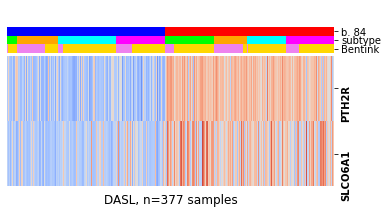

In [50]:
bics = rename_genes_in_biclusters(dasl_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
if w>h:
    cr = max(min(0.015,0.05*h/10),0.05)
else:
    cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_dasl_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_dasl.loc[:,["subtype","Bentink"]], # 
                    #annot = subt_dasl.loc[:,["subtype"]],
                    color_dict= color_dict,
                  #bicluster_colors="black",
                  bicluster_colors="redblue",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  highlight_row_labels=highlight_genes,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = True,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%subt_dasl.shape[0], fontsize=fs)

In [51]:
gene_sets_stat_tcga.loc[129,:]

genes               {ENSG00000239961, ENSG00000164485, ENSG0000021...
n_genes                                                           128
genes_measured      [ENSG00000095917, ENSG00000100721, ENSG0000010...
n_genes_measured                                                  103
genes2              {ENSG00000239961, ENSG00000211946, ENSG0000010...
n_genes2                                                           80
SNR                                                          1.575306
SNR2                                                         1.613471
Name: 129, dtype: object

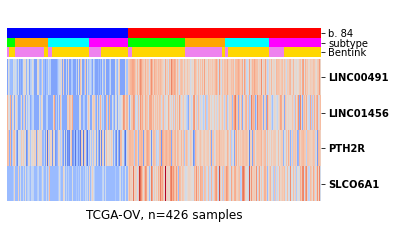

In [52]:
w = 6
fs = 12 # Font size

bics = rename_genes_in_biclusters(tcga_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
if w>h:
    cr = max(min(0.015,0.05*h/10),0.05)
else:
    cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_tcga_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_tcga.loc[:,["subtype","Bentink"]], #,"Bentink"
                    color_dict= color_dict,
                  bicluster_colors="redblue",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  col_labels = False,
                  highlight_row_labels=highlight_genes,
                  row_labels = True,
                  no_row_colors = True,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=fs)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

In [53]:
color_dict[cl].keys()

odict_keys(['proliferative', 'mesenchymal', 'differentiated', 'immunoreactive', 'PRO', 'MES', 'DIF', 'IMR'])

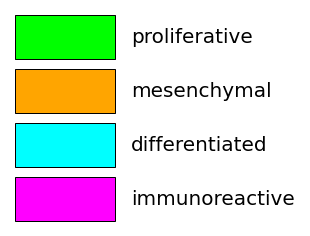

In [54]:
from matplotlib.patches import Patch

cl = "subtype"
legend_elements = []
for subt in ['proliferative', 'mesenchymal', 'differentiated', 'immunoreactive']:#["PRO","MES","DIF","IMR"]
    p = Patch(facecolor=color_dict[cl][subt], edgecolor='black', label=subt)
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (3,3))
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=1,
    handlelength=5,
    handleheight=3,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)

legend.get_frame().set_alpha(0)

legend.set_title('', prop={'size': 22})

ax.axis('off')


#plt.show()
plt.savefig("../img/Fig3.subt_lenend.pdf")

### top-5 largest biclusters found in both TCGA-RNAseq and UKE

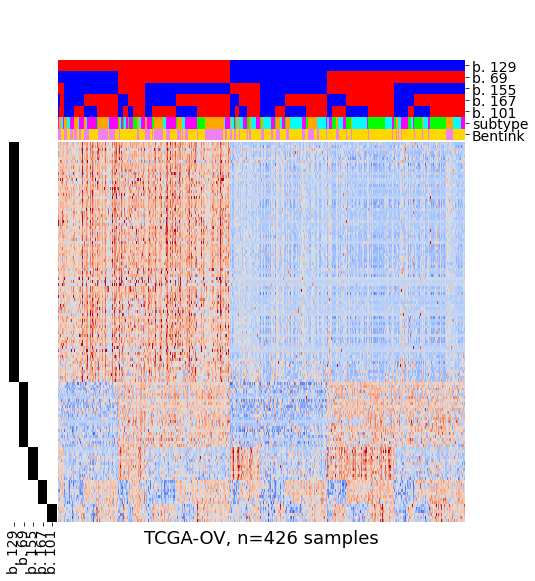

In [55]:
# show some biclusters with many genes in UKE and TCGA
sele_bics = tcga_bics.loc[uke_ids.intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False).head(5).index.values#[40,63,129,70] #[84,130] # 129, 69, 20 27?  # ####129,  57,  69,  27,  20,  85,  47

highlight_genes = []
for bic_id in sele_bics:
    genes = dasl_bics.loc[bic_id,"genes"]| tcga_bics.loc[bic_id,"genes"]
    genes = genes.intersection(uke_bics.loc[bic_id,"genes"])
    highlight_genes+= sorted(genes)
highlight_genes = sorted(set(highlight_genes))
highlight_genes =  [rename_gene(x, keep_not_mapped=True) for x in highlight_genes]

w = 8
bics = rename_genes_in_biclusters(tcga_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
if w>h:
    cr = max(min(0.015,0.05*h/10),0.05)
else:
    cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_tcga_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_tcga.loc[:,["subtype","Bentink"]], #,"Bentink"
                    color_dict= color_dict,
                  #bicluster_colors="auto",
                  #bicluster_colors="black",
                  bicluster_colors="redblue",
                  figsize = (w,h*0.8), 
                  dendrogram_ratio=(0.1,0.1),
                  colors_ratio=(cr/w*h, cr*1.5),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  col_labels = False,
                  #highlight_row_labels=highlight_genes,
                  #row_labels = True,
                  no_row_colors = False,
                  cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=18)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

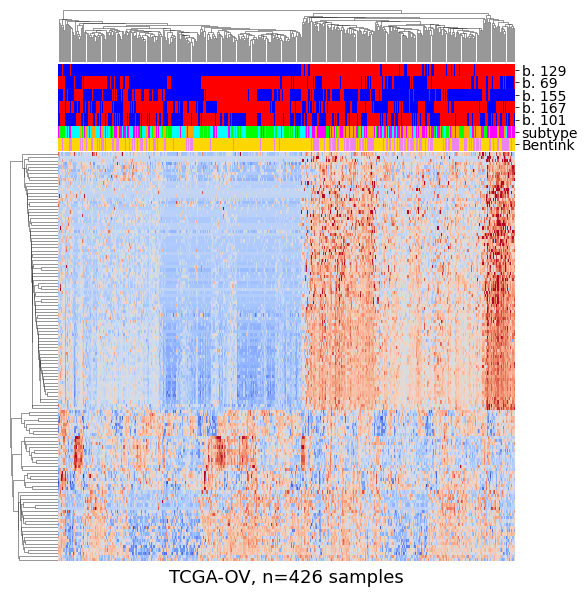

In [56]:
df = colors[0].copy()
d = {"white":0,"black":1}
df = df.applymap(lambda x:d[x])
df = df[df.sum(axis=1)>0]
df = df.sort_values(by=list(df.columns.values),ascending=False)
fig = sns.clustermap(fig.data2d.loc[list(df.index.values),
                                    samples],
                       col_cluster=True,#row_cluster=True,
                       cmap=sns.color_palette("coolwarm", as_cmap=True),
                       vmin=-3,vmax=3,
                       xticklabels=False, yticklabels=False,
                       col_colors=colors[1],
                       #row_colors=colors[0],
                       figsize=(w,h*0.8), 
                       dendrogram_ratio=(0.1,0.1),
                       colors_ratio=(cr/w*h, cr*1.5),)
fig.cax.set_visible(False)
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0],fontsize=18)
tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
#tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

In [57]:
"""cols = ["bic"+str(x) for x in [84,130]]
df = pd.DataFrame(np.zeros((exprs_tcga.shape[1],len(cols))),
             index=exprs_tcga.columns,
             columns=cols)
for bic_id in [84,130]:
    df.loc[tcga_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1
df = df.applymap(lambda x: int(x))
df.to_csv("TCGA-OV_426.design.tsv",sep ="\t")

# wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_gene_expected_count.gz
# PanCan  RNAseq - TOIL RSEM expected_count  log2(x+1) transformed
tcga_counts = pd.read_csv("../data/tcga_gene_expected_count.gz",
                          sep = "\t",
                          index_col=0,
                          usecols = ["sample"]+list(df.index.values))
tcga_counts.index = [x.split(".")[0] for x in tcga_counts.index]
tcga_counts = tcga_counts.applymap(lambda x: 2**x-1)
tcga_counts.to_csv("../data/TCGA-OV426.est_counts.tsv",sep= "\t")
# keep only genes in UKE
tcga_counts = tcga_counts.loc[[g for g in tcga_counts.index if g in exprs.index],df.index]
tcga_counts.applymap(lambda x: int(round(x))).to_csv("../data/TCGA-OV_noENSG00000230417_UKEgenes.est_counts_rounded.tsv",sep= "\t")
"""

'cols = ["bic"+str(x) for x in [84,130]]\ndf = pd.DataFrame(np.zeros((exprs_tcga.shape[1],len(cols))),\n             index=exprs_tcga.columns,\n             columns=cols)\nfor bic_id in [84,130]:\n    df.loc[tcga_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1\ndf = df.applymap(lambda x: int(x))\ndf.to_csv("TCGA-OV_426.design.tsv",sep ="\t")\n\n# wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_gene_expected_count.gz\n# PanCan  RNAseq - TOIL RSEM expected_count  log2(x+1) transformed\ntcga_counts = pd.read_csv("../data/tcga_gene_expected_count.gz",\n                          sep = "\t",\n                          index_col=0,\n                          usecols = ["sample"]+list(df.index.values))\ntcga_counts.index = [x.split(".")[0] for x in tcga_counts.index]\ntcga_counts = tcga_counts.applymap(lambda x: 2**x-1)\ntcga_counts.to_csv("../data/TCGA-OV426.est_counts.tsv",sep= "\t")\n# keep only genes in UKE\ntcga_counts = tcga_counts.loc[[g for g in tcga_counts.index if

# Bicluster 84 in all three cohorts 

In [58]:
def read_limma(tsv_file,exprs):
    df = pd.read_csv(tsv_file,sep ="\t",index_col=0)
    cols = list(df.columns.values)
    df["gene"] = df.index
    df["gene"] = df["gene"].apply(lambda x: rename_gene(x))
    df = df.loc[:,["gene"]+cols]
    df = add_avg_exprs(df, exprs,col_name = "avgLog2exprs")
    df = df.sort_values(by="adj.P.Val" )
    df["rank"] = df["adj.P.Val"].rank()
    return df

def add_avg_exprs(df, exprs,col_name = "avgLog2exprs"):
    df[col_name ] = np.nan
    shared  =  sorted(set(df.index.values).intersection(set(exprs.index.values)))
    df.loc[shared,col_name ] = exprs.loc[shared ,:].mean(axis=1)
    return df

In [59]:
lfc = 1
p = 0.05
b = 84
df_uke = read_limma("bic"+str(b)+"_UKE181.DE.tsv",exprs)
df_dasl = read_limma("bic"+str(b)+"_DASL377.DE.tsv",exprs_dasl)
df_tcga = read_limma("bic"+str(b)+"_TCGA-OV426.DE.tsv",exprs_tcga)

#shared_genes = set(df_uke.index).intersection(set(df_tcga.index))#.intersection(set(df_dasl.index))
shared_uke_dals = set(df_uke.index).intersection(set(df_dasl.index))
shared_uke_tcga = set(df_uke.index).intersection(set(df_tcga.index))
shared_dals_tcga = set(df_tcga.index).intersection(set(df_dasl.index))
shared_genes = set(df_uke.index).union(set(df_tcga.index)).union(set(df_dasl.index))
print("shared_genes",len(shared_genes))


de_uke  =df_uke.loc[df_uke["adj.P.Val"]<p,:]
de_dasl  = df_dasl.loc[df_dasl["adj.P.Val"]<p,:]
de_tcga = df_tcga.loc[df_tcga["adj.P.Val"]<p,:]



if lfc >0:
    uke_up  = set(de_uke.loc[de_uke["logFC"]>lfc,:].index.values).intersection(shared_genes)
    dasl_up  = set(de_dasl.loc[de_dasl["logFC"]>lfc,:].index.values).intersection(shared_genes)
    tcga_up = set(de_tcga.loc[de_tcga["logFC"]>lfc,:].index.values).intersection(shared_genes)
    
    uke_down  = set(de_uke.loc[de_uke["logFC"]<-lfc,:].index.values).intersection(shared_genes)
    dasl_down  = set(de_dasl.loc[de_dasl["logFC"]<-lfc,:].index.values).intersection(shared_genes)
    tcga_down = set(de_tcga.loc[de_tcga["logFC"]<-lfc,:].index.values).intersection(shared_genes)
    
else:
    uke_up  = set(de_uke.loc[de_uke["logFC"]<lfc,:].index.values).intersection(shared_genes)
    dasl_up  = set(de_dasl.loc[de_dasl["logFC"]<lfc,:].index.values).intersection(shared_genes)
    tcga_up= set(de_tcga.loc[de_tcga["logFC"]<lfc,:].index.values).intersection(shared_genes)
    
    uke_down  = set(de_uke.loc[de_uke["logFC"]>-lfc,:].index.values).intersection(shared_genes)
    dasl_down = set(de_dasl.loc[de_dasl["logFC"]>-lfc,:].index.values).intersection(shared_genes)
    tcga_down = set(de_tcga.loc[de_tcga["logFC"]>-lfc,:].index.values).intersection(shared_genes)

de_uke = uke_up|uke_down
de_dasl = dasl_up|dasl_down
de_tcga = tcga_up|tcga_down
    
len(de_uke),len(de_dasl),len(de_tcga)

shared_genes 28207


(312, 49, 683)

In [64]:
len(shared_uke_dals)

15583

In [60]:
from scipy.stats import fisher_exact
# UKE vs DASL
o = 14
n = len(shared_uke_dals)
statistics, pval = fisher_exact([[o, 118-o],[46-o, n - 118 - 46 + o ]], alternative="greater")
print("UKE vs DASL:overlap p-value:%.2e"%pval )


o = 212
n = len(shared_uke_tcga)
statistics, pval = fisher_exact([[o, 290-o],[669-o, n - 290 - 669 + o ]], alternative="greater")
print("UKE vs TCGA-OV:overlap p-value:%.2e"%pval )

UKE vs DASL:overlap p-value:1.80e-19
UKE vs TCGA-OV:overlap p-value:6.30e-269


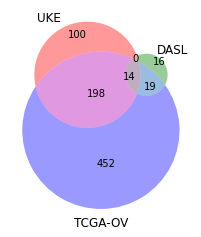

In [61]:
from matplotlib_venn import venn3, venn2

v = venn3([de_uke,de_dasl,de_tcga],
          set_labels=("UKE","DASL","TCGA-OV")
         )
#tmp = plt.title("bicluster "+str(b),fontsize=14)
plt.savefig("../img/Fig3_bic84_gene_sets.pdf")

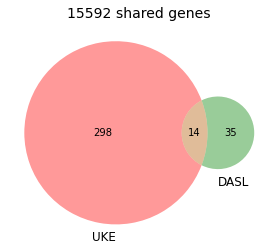

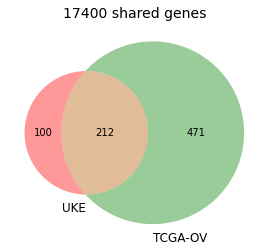

In [62]:
v = venn2([de_uke,de_dasl],
          set_labels=("UKE","DASL")
         )
tmp = plt.title("%s shared genes"%str(15592),fontsize=14)
plt.show()

v = venn2([de_uke,de_tcga],
          set_labels=("UKE","TCGA-OV")
         )
tmp = plt.title("%s shared genes"%str(17400),fontsize=14)
plt.show()

In [63]:
len(set(de_uke.intersection(de_tcga)))

212

shared genes: 15492
signif. in UKE: 113 signif. in DASL: 34
significant in both 13
significant in at least one dataset 134


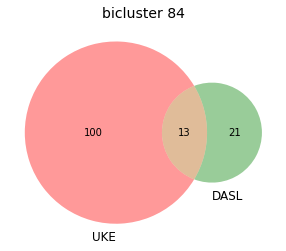

,gene,UKE_logFC,UKE_adj.P.Val,UKE_avgLog2exprs,UKE_rank,DASL_logFC,DASL_adj.P.Val,DASL_avgLog2exprs,DASL_rank,avg_rank
gene_id,,,,,,,,,,
ENSG00000205359,SLCO6A1,3.610710,6.827249e-40,2.401567,2.0,1.930636,5.788021e-33,7.656167,2.0,2.00
ENSG00000084453,SLCO1A2,2.597286,5.831795e-08,4.685145,20.0,1.081157,3.788957e-13,6.121194,5.0,12.50
ENSG00000144407,PTH2R,2.918521,9.135928e-07,5.776959,36.0,3.935389,1.469472e-86,9.507736,1.0,18.50
ENSG00000127928,GNGT1,1.926976,5.165309e-07,5.084154,35.0,1.381456,3.006943e-13,7.939428,4.0,19.50
ENSG00000133710,SPINK5,1.976104,1.730418e-07,6.814876,26.0,1.040379,8.840066e-07,10.245764,83.0,54.50
ENSG00000176204,LRRTM4,1.873221,1.084620e-04,2.435715,96.0,1.027032,1.230601e-07,7.997956,31.5,63.75
ENSG00000124092,CTCFL,2.054593,5.926518e-04,7.741535,135.0,1.576616,3.686130e-07,11.021222,51.0,93.00
ENSG00000280409,LINC01101,1.224104,1.341776e-03,3.846328,183.0,1.643674,4.389658e-10,9.318886,12.0,97.50
ENSG00000267313,,2.385125,1.080929e-05,2.741302,61.0,0.479585,1.998411e-05,6.795675,218.0,139.50


In [64]:
b = 84
de_uke = read_limma("bic"+str(b)+"_UKE181.DE.tsv",exprs).dropna()
de_dasl = read_limma("bic"+str(b)+"_DASL377.DE.tsv",exprs_dasl).dropna()


def make_joined_table(df1_, df2_, b=84,
                      lfc=1,p=0.05,
                      name1="UKE",name2="DASL",
                      flip_lFC_sign=True,
                      upreg = True,
                      plot= True,
                      subset="any" # "any","both"
                      ):
    shared_genes = set(df1_.index).intersection(set(df2_.index))
    print("shared genes:",len(shared_genes))
    df1 = df1_.copy()
    df1 = df1.loc[sorted(shared_genes),["gene","logFC","adj.P.Val","avgLog2exprs","rank"]]
    df1.columns = ["gene"]+[name1+"_"+x for x in ["logFC","adj.P.Val","avgLog2exprs","rank"]]

    df2 = df2_.copy()
    df2 = df2.loc[sorted(shared_genes),["logFC","adj.P.Val","avgLog2exprs","rank"]]
    df2.columns = [name2+"_"+x for x in df2.columns]

    df = pd.concat([df1,df2],axis=1)
    if flip_lFC_sign:
        # logFC sign is  flipped to compare benefit vs no benefit groups
        df[name1+"_logFC"] = df[name1+"_logFC"] * -1
        df[name2+"_logFC"] = df[name2+"_logFC"] * -1

    if upreg:
        d = df.loc[df[name1+"_logFC"]>lfc,:]
    else:
        d = df.loc[df[name1+"_logFC"]<-lfc,:]
    d = d.loc[d[name1+"_adj.P.Val"]<p,:]
    signif1 = set(d.index)
    
    if upreg:
        d = df.loc[df[name2+"_logFC"]>lfc,:]
    else:
        d = df.loc[df[name2+"_logFC"]<-lfc,:]
    d = d.loc[d[name2+"_adj.P.Val"]<p,:]
    signif2 = set(d.index)
    
    print("signif. in "+name1+":",len(signif1),"signif. in "+name2+":" , len(signif2))
    signif_both = signif1.intersection(signif2)
    signif_any = signif1.union(signif2)
    print("significant in both",len(signif_both))
    print("significant in at least one dataset",len(signif_any))

    df["avg_rank"] = df.loc[:,[name1+"_rank",name2+"_rank"]].mean(axis=1)
    df = df.sort_values("avg_rank")
    df.index.names = ["gene_id"]
    
    if plot:
        from matplotlib_venn import venn2
        v = venn2([signif1,signif2],set_labels=(name1,name2))
        tmp = plt.title("bicluster "+str(b),fontsize=14)
        plt.show()
    if subset=="any":
        return df.loc[list(signif_any),:].sort_values("avg_rank")
    if subset=="both":
        return df.loc[list(signif_both),:].sort_values("avg_rank")

make_joined_table(de_uke, de_dasl, b=b,
                      lfc=1,p=0.05,
                      name1="UKE",name2="DASL",
                      flip_lFC_sign=True,
                      upreg = True,
                      plot= True).head(20)
###df.to_csv("tables/bic"+str(b)+"_DE.UKE_and_DASL.tsv",sep="\t")

shared genes: 17095
signif. in UKE: 160 signif. in TCGA-OV: 375
significant in both 113
significant in at least one dataset 422


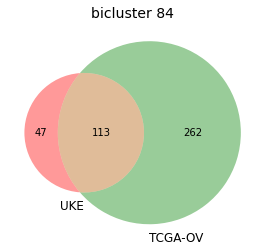

,gene,UKE_logFC,UKE_adj.P.Val,UKE_avgLog2exprs,UKE_rank,TCGA-OV_logFC,TCGA-OV_adj.P.Val,TCGA-OV_avgLog2exprs,TCGA-OV_rank,avg_rank
gene_id,,,,,,,,,,
ENSG00000250682,LINC00491,4.201250,1.836650e-45,3.551832,1.0,4.579023,2.012166e-90,3.997561,1.0,1.00
ENSG00000205359,SLCO6A1,3.610710,6.827249e-40,2.401567,2.0,3.349377,2.255410e-66,2.172203,2.0,2.00
ENSG00000237978,KCNMB2-AS1,2.404369,3.255860e-10,5.135031,7.5,3.441285,1.945509e-26,5.656466,7.0,7.25
ENSG00000225882,LINC01456,2.262610,3.093444e-12,2.633569,6.0,2.227446,4.896733e-25,2.640376,11.5,8.75
ENSG00000254560,BBOX1-AS1,1.619708,9.701809e-08,5.131590,24.0,2.665955,1.027597e-27,5.880524,6.0,15.00
...,...,...,...,...,...,...,...,...,...,...
ENSG00000235621,LINC00494,1.078886,1.805299e-02,4.226689,618.0,1.027370,9.631520e-05,4.395516,2207.0,1412.50
ENSG00000248131,LINC01194,1.018511,4.978932e-02,1.127613,1259.5,1.335705,9.769387e-05,1.458269,2213.0,1736.25
ENSG00000150275,PCDH15,1.248629,4.700526e-02,2.722411,1193.0,1.283140,1.131788e-04,2.902635,2285.0,1739.00


In [65]:
b = 84
lfc=1
p=0.05
de_uke = read_limma("bic"+str(b)+"_UKE181.DE.tsv",exprs).dropna()
de_dasl = read_limma("bic"+str(b)+"_DASL377.DE.tsv",exprs_dasl).dropna()
de_tcga = read_limma("bic"+str(b)+"_TCGA-OV426.DE.tsv",exprs_tcga).dropna()
df_up = make_joined_table(de_uke, de_tcga, b=b,
                      lfc=lfc,p=p,
                      name1="UKE",name2="TCGA-OV",
                      flip_lFC_sign=True,
                      upreg = True,
                      plot = True,
                      subset ="both")
df_up

In [65]:
#df_up.to_csv("tables/bic"+str(b)+"_DE_up.UKE_and_TCGA-OV_signif_in_both.tsv",sep="\t")

In [66]:
# only genes presenting in both UKE and DASL are accounted
import gseapy
names = gseapy.get_library_name()

#annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)
shared_samples = sorted(set(exprs.columns.values).intersection(set(annot.index.values)))
shared_genes = sorted(set(exprs.index.values).intersection(set(exprs_tcga.index.values)))
#exprs = exprs.loc[:,shared_samples]
#annot = annot.loc[shared_samples,:]

bg_gene_names = [rename_gene(x) for x in shared_genes if len(rename_gene(x))>0]
bg_gene_names = sorted(bg_gene_names)
exprs_g_names = exprs.loc[:,:].copy()
exprs_g_names.index = [rename_gene(x,keep_not_mapped=True) for x in exprs.index.values]
exprs_g_names = exprs_g_names.loc[bg_gene_names,:]
print(len(bg_gene_names))

17400


In [67]:
gset_dbs = ['GO_Molecular_Function_2023', 
            'GO_Biological_Process_2023',
            'Reactome_2022',
            'WikiPathway_2023_Human',
            'KEGG_2021_Human',
            'CORUM',
            'GTEx_Tissues_V8_2023',
            'CellMarker_2024',
            'Descartes_Cell_Types_and_Tissue_2021',
            'Tabula_Sapiens']

gset_stats  = {}
## download databases, extract datasets, overlap with background
for db in gset_dbs:
    gset_stats[db] = {}
    gset_db = gseapy.get_library(name=db, organism='human')
    print(db, len(gset_db.keys()))
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs = set(gset).intersection(set(bg_gene_names))
        #print(db, gs, len(gset),len(gset_exprs), gset_exprs)
        gset_stats[db][gs] = gset_exprs

GO_Molecular_Function_2023 1147
GO_Biological_Process_2023 5406
Reactome_2022 1816
WikiPathway_2023_Human 801
KEGG_2021_Human 320
CORUM 1658
GTEx_Tissues_V8_2023 511
CellMarker_2024 1692
Descartes_Cell_Types_and_Tissue_2021 172
Tabula_Sapiens 469


In [68]:
from openpyxl import load_workbook

xls_flie = 'tables/S4C_ORA_bic'+str(b)+'_p'+str(p)+'_lfc'+str(lfc)+'.xlsx'

with pd.ExcelWriter(xls_flie, engine='openpyxl') as writer:
    if not os.path.exists(xls_flie):
        pd.DataFrame().to_excel(writer, engine='openpyxl', sheet_name= "description")

    de = pd.read_csv("tables/bic"+str(b)+"_DE_up.UKE_and_TCGA-OV_signif_in_both.tsv",sep="\t",index_col=0)
    de = de.loc[de["UKE_adj.P.Val"]<p,:]
    de = de.loc[de["TCGA-OV_adj.P.Val"]<p,:]
    if b == 84:
        de = de.loc[de["UKE_logFC"]>lfc,:]
        de = de.loc[de["TCGA-OV_logFC"]>lfc,:]
    if b == 130:
        de = de.loc[de["UKE_logFC"]<-lfc,:]
        de = de.loc[de["TCGA-OV_logFC"]<-lfc,:]
    gene_list = [x for x in list(de["gene"].values) if type(x)==str]
    print("n genes:", len(gene_list))
    gp_output = gseapy.enrichr(gene_list=gene_list,
                               gene_sets=gset_dbs,
                               organism="human",
                               background=bg_gene_names,
                               outdir="gseapy/",
                               no_plot=True
                              )
    res = gp_output.results
    res = res.loc[res["Adjusted P-value"]<0.05,:].copy()

    res['genes'] =  res['Genes'].apply(lambda x: " ".join(sorted(x.split(";"))))
    try:
        res["db_gset_size"] = res.apply(lambda x: len(gset_stats[x["Gene_set"]][x["Term"]]),axis=1)
    except:
        res["db_gset_size"] = np.nan
    res["overlap_size"] =  res['Genes'].apply(lambda x: len(sorted(x.split(";"))))

    res['bicluster_id'] = b
    cols = ['bicluster_id','Gene_set', 'Term',  'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score',
            'overlap_size', 'db_gset_size', 'genes']
    res = res.loc[res["overlap_size"]>1,cols]
    res["Gene_set_collection"] = res["Gene_set"]
    res["gene_set_name"] = res["Term"]

    cols = ['Gene_set_collection', 'gene_set_name', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'overlap_size', 'genes']
    res = res.loc[:,cols].drop_duplicates(subset=["genes","Gene_set_collection"])
    res = res.sort_values(by = ["Adjusted P-value","Odds Ratio","genes","Gene_set_collection"],
                            ascending  = [True, False,True, True])
    res["bicluster"] = b
    res = res.set_index("gene_set_name")
    print( "bic."+str(b), "genes in query set:",len(gene_list),"DB gene sets passed:", res.shape[0])
    res.to_excel(writer, engine='openpyxl', sheet_name= "bic."+str(b))


n genes: 113
bic.84 genes in query set: 113 DB gene sets passed: 24


In [69]:
 #res.to_excel(writer, engine='openpyxl', sheet_name= "bic."+str(b))

In [70]:
gset_dbs2 = ['GO_Molecular_Function_2023',
 'Reactome_2022',
 'WikiPathway_2023_Human',
 'KEGG_2021_Human',
 'GTEx_Tissues_V8_2023',
 'CellMarker_2024',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Tabula_Sapiens']

In [ ]:
### GSEA
gsea_results = {}
for bic_id in [b]:
    # make cls files
    #design = pd.read_csv("UKE_181.design.tsv",sep ="\t",index_col=0)
    #design = design.loc[:,["bic"+str(bic_id)]] 
    #exprs_g_names = exprs_g_names.loc[:,design.index]
    design = pd.read_csv("TCGA-OV_426.design.tsv",sep ="\t",index_col=0)
    design = design.loc[:,["bic"+str(bic_id)]] 
    exprs_g_names = exprs_tcga.loc[:,:].copy()
    exprs_g_names.index = [rename_gene(x,keep_not_mapped=True) for x in exprs_tcga.index.values]
    exprs_g_names = exprs_g_names.loc[bg_gene_names,:]
    
    groups = list(design["bic"+str(bic_id)].values)
    gr1, gr2 = 1, 0
    cls_file = 'bic'+str(bic_id)+'.cls'
    with open(cls_file, "w") as cl:
        line = f"{len(groups)} 2 1\n# "+str(gr1)+" "+str(gr2)+"\n"
        cl.write(line)
        cl.write(" ".join(map(str,groups)) + "\n")
        
    print("Gene set:", bic_id)
    # run gsea
    bic_gsea_results = []
    for db in gset_dbs2:
        print(db)
        gsea_res = gseapy.gsea(data=exprs_g_names, 
                     gene_sets=db,
                     cls= cls_file, 
                     permutation_type='phenotype',
                     permutation_num=1000, # reduce number to speed up test
                     max_size=200, min_size=5, # min and max DB gene set sizes
                     outdir=None,  # do not write output to disk
                     method='signal_to_noise',
                     seed=0,verbose=True)
        res = gsea_res.res2d.loc[:,:].copy()
        res["genes"] = res["Lead_genes"].apply(lambda x: " ".join(x.split(";")))
        res["overlap_size"] = res["Lead_genes"].apply(lambda x: len(x.split(";")))
        res["DB"] = db
        res["query_gene_set"] = bic_id
        bic_gsea_results.append(res)
    bic_gsea_results = pd.concat(bic_gsea_results,axis=0).sort_values(by = "FDR q-val")
    gsea_results[bic_id] = bic_gsea_results

2025-02-14 14:37:07,440 [INFO] Parsing data files for GSEA.............................


Gene set: 84
GO_Molecular_Function_2023


2025-02-14 14:37:10,057 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-14 14:37:10,082 [INFO] 0142 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-14 14:37:10,083 [INFO] 1005 gene_sets used for further statistical testing.....
2025-02-14 14:37:10,084 [INFO] Start to run GSEA...Might take a while..................
2025-02-14 14:49:47,029 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-14 14:49:47,168 [INFO] Parsing data files for GSEA.............................


Reactome_2022


2025-02-14 14:50:40,678 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-14 14:50:40,830 [INFO] 0132 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-14 14:50:40,833 [INFO] 1686 gene_sets used for further statistical testing.....
2025-02-14 14:50:40,834 [INFO] Start to run GSEA...Might take a while..................


In [ ]:
cols = ['DB', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       #'Tag %', 'Gene %', 'query_gene_set'
        'Lead_genes', 'genes', 'overlap_size',
       ]
ds = "TCGA-OV"
with pd.ExcelWriter("tables/GSEA_"+ds+"_bic"+str()+"_GSEA.xlsx", engine='openpyxl') as writer:
    for bic_id in [b]:
        df = gsea_results[bic_id]
        df = df.sort_values(by = ["FDR q-val"],
                            ascending  = [True])
        print("Tested gene sets:", df.shape[0])
        df = df.loc[df["FDR q-val"]<0.05,:]
        print("Passed gene sets:", df.shape[0])
        df = df.loc[:,cols]
        df = df.set_index("Term")
        df.to_excel(writer, sheet_name= "bic."+str(bic_id)) 


### Plot DE genes with FC>1 in bic. 84 in the UKE and DASL (fig. 3)

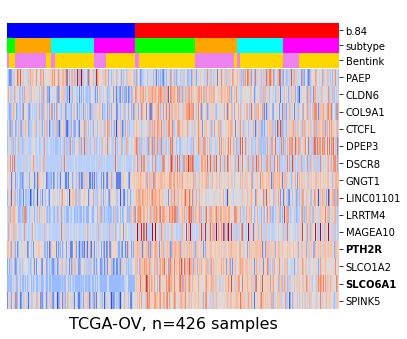

In [68]:
fs = 12
i = [84]
b = tcga_bics.loc[i,:].copy()

b["genes_up"] = [{"PAEP"}]
b["genes_down"] = [{'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]
b["genes"] = [{"PAEP",'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]


fig = draw_heatmap2(exprs_tcga_z_rn.loc[:,subt_tcga.index], b,
                    annot=subt_tcga.loc[:,["subtype","Bentink"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (4*1.5,3*1.5), 
              dendrogram_ratio=(0.05,0.05),
              colors_ratio=(0.03, 0.05),
              bic_prefix = "b.",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              color_range=(-3,3),
              highlight_row_labels=['PTH2R', 'SLCO6A1'],
              no_row_colors = True,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=16)
plt.savefig("../img/Fig3_bic84_TCGA-OV_heatmap.pdf")
plt.show()

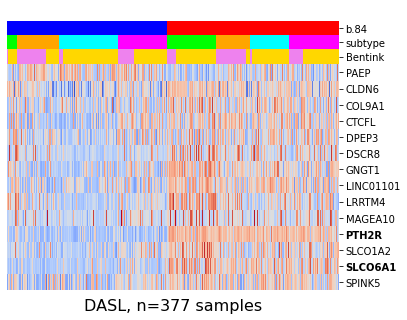

In [69]:
fs = 12
i = [84]
b = dasl_bics.loc[i,:].copy()

b["genes_up"] = [{"PAEP"}]
b["genes_down"] = [{'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]
b["genes"] = [{"PAEP",'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]


fig = draw_heatmap2(exprs_dasl_z_rn.loc[:,subt_dasl.index], b,
                    annot=subt_dasl.loc[:,["subtype","Bentink"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (4*1.5,3*1.5), 
              dendrogram_ratio=(0.05,0.05),
              colors_ratio=(0.03, 0.05),
              bic_prefix = "b.",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              color_range=(-3,3),
              highlight_row_labels=['PTH2R', 'SLCO6A1'],
              no_row_colors = True,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%subt_dasl.shape[0], fontsize=16)
plt.savefig("../img/Fig3_bic84_DASL_heatmap.pdf")
plt.show()

In [70]:
#sys.path.append('/home/olya/TUM/DESMOND/DESMOND2/unpast/') # path to UnPaSt
#from unpast.utils.figs import draw_heatmap2

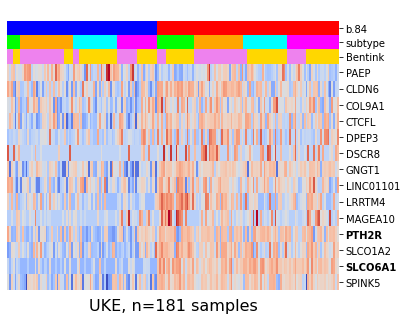

In [71]:
fs = 12
i = [84]
b = uke_bics.loc[i,:].copy()

b["genes_up"] = [{"PAEP"}]
b["genes_down"] = [{'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]
b["genes"] = [{"PAEP",'CLDN6', 'SPINK5', 'CTCFL', 'MAGEA10', 'PTH2R', 'GNGT1', 
                    'DPEP3', 'LRRTM4', 'SLCO6A1', 'SLCO1A2', 'DSCR8', 'LINC01101', 'COL9A1'}]


fig = draw_heatmap2(exprs_uke_z_rn.loc[:,subt_uke.index], b,
                    annot=subt_uke.loc[:,["subtype","Bentink"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (4*1.5,3*1.5), 
              dendrogram_ratio=(0.05,0.05),
              colors_ratio=(0.03, 0.05),
              bic_prefix = "b.",
              #no_legend=False,
               legend_n_cols=0,
                no_cbar=True,
              col_labels = False,
              row_labels = True,
              color_range=(-3,3),
              highlight_row_labels=['PTH2R', 'SLCO6A1'],
              no_row_colors = True,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%subt_uke.shape[0], fontsize=16)
plt.savefig("../img/Fig3_bic84_UKE_heatmap.pdf")
plt.show()

# Bicluster examples 

109
327


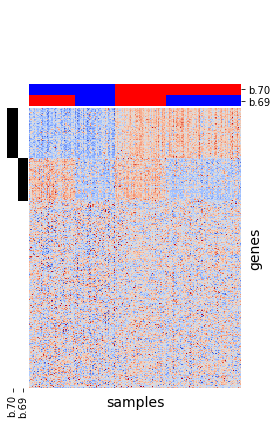

In [72]:
b = uke_bics.loc[[70,69],:]#.head(3) #27
#b = biclusters.loc[[163,101,84],:]
b["samples"] = b["samples"].apply(lambda x: x.intersection(set(annot.index)))
b["n_samples"] = b["samples"].apply(lambda x: len(x))
e = exprs_uke_z.loc[:,annot_uke.index]
genes = set([])
for bic_id in b.index.values:
    genes |= b.loc[bic_id,"genes"]
print(len(genes))
# randomly picked gene
random.seed(0)
genes |= set(random.sample(set(e.index.values).difference(genes), len(genes)*2))
genes = sorted(genes)
random.shuffle(genes)
e = e.loc[genes,annot.index]
print(e.shape[0])
figsize = (4,6)

g, sample_order, (row_colors, col_colors) = draw_heatmap2(e,
                    b,
                    color_dict=color_dict,
                    figsize=(4,6),
                    color_range=(-3,3),
                    #dendrogram_ratio=(0.1,0.1),
                    colors_ratio=(0.015*3,0.015*8/4),
                    bicluster_colors = "redblue",
                    no_cbar=True,
                    legend_n_cols=0,
                    no_row_colors=False,
                    cluster_rows=False,
                    row_labels=False,
                    col_labels=False,
                    plot_bg_genes=True, 
                    bic_prefix="b.",
                    )
tmp = g.ax_heatmap.set_xlabel("samples",fontsize=14)
tmp = g.ax_heatmap.set_ylabel("genes",fontsize=14)
#tmp = plt.savefig('img/Bic_example1.png')
#tmp = plt.savefig('img/Bic_example1.svg')

In [73]:
328-109

219

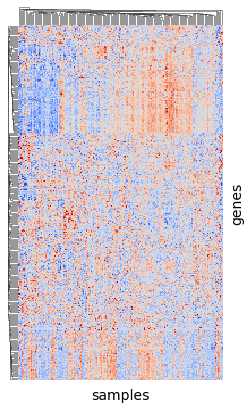

In [74]:
g = sns.clustermap(e,figsize=(3.3,5.75),
                       col_cluster=True,
                       row_cluster=True,
                      dendrogram_ratio=(0.05,0.05),#colors_ratio=colors_ratio,
                       cmap=sns.color_palette("coolwarm", as_cmap=True),
                       vmin=-3,vmax=3,
                       xticklabels=False, yticklabels=False,
                       #col_colors=col_colors,
                      #row_colors = row_colors
                  )
g.ax_cbar.set_visible(False)
#g.ax_col_dendrogram.set_visible(False)
#g.ax_row_dendrogram.set_visible(False)
tmp = g.ax_heatmap.set_xlabel("samples",fontsize=14)
tmp = g.ax_heatmap.set_ylabel("genes",fontsize=14)
tmp = plt.savefig('img/Bic_example2.png')
#tmp = plt.savefig('img/Bic_example2.svg')

In [75]:
ids23  = [ 10,  22,  27,  31,  34,  41,  59,  60,  62,  70,  72,  83,  84,
        85,  90,  95, 103, 109, 117, 130, 144, 155, 168]
ids_rep7 = [129,  57,  69,  27, 103,  20,  85]

264
264


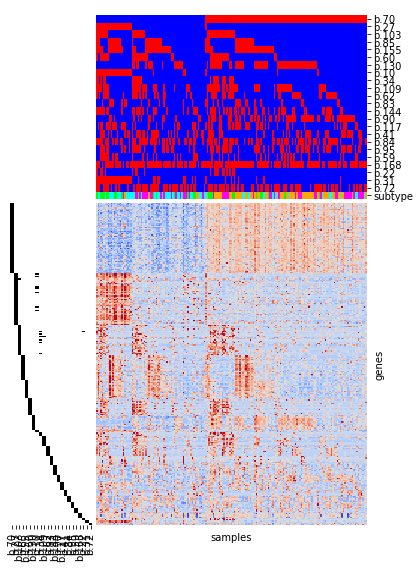

In [76]:
b = uke_bics.loc[ids23,:].sort_values(by = ["n_genes","SNR"],ascending = [False,False])#.head(3) #27
#b = biclusters.loc[[163,101,84],:]
b["samples"] = b["samples"].apply(lambda x: x.intersection(set(annot.index)))
b["n_samples"] = b["samples"].apply(lambda x: len(x))
e = exprs_uke_z.loc[:,annot_uke.index]
genes = set([])
for bic_id in b.index.values:
    genes |= b.loc[bic_id,"genes"]
print(len(genes))
# randomly picked gene
random.seed(0)
genes |= set(random.sample(set(e.index.values).difference(genes), int(len(genes)*0)))
genes = sorted(genes)
random.shuffle(genes)
e = e.loc[genes,annot.index]
print(e.shape[0])
figsize = (4,6)

g, sample_order, (row_colors, col_colors) = draw_heatmap2(e,
                    b,
                    annot=subt_uke.loc[e.columns,["subtype"]].copy(),
                    color_dict=color_dict,
                    figsize=(6,8),
                    color_range=(-3,3),
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.01, 0.015),
                    #colors_ratio=(0.015*3,0.015*8/4),
                    bicluster_colors = "redblue",
                    no_cbar=True,
                    legend_n_cols=0,
                    no_row_colors=False,
                    cluster_rows=False,
                    row_labels=False,
                    col_labels=False,
                    plot_bg_genes=True,
                    bic_prefix="b.")
tmp = g.ax_heatmap.set_xlabel("samples")
tmp = g.ax_heatmap.set_ylabel("genes")
#tmp = plt.savefig('img/Bic_example3.png')